![haceb](haceb.png)
# **Prueba Técnica - Científico de Datos monetización de Crédito**
## Prueba Analítica: Modelo score de crédito
### Científico de Datos:

* Daniel Felipe Pérez Grajales . dfperezg@unal.edu.co<br>

<br><br>


---
<br>

**Objetivo:**

Esta prueba analítica tiene como objetivo diseñar y desarrollar un modelo de pronóstico scorecard.


**Los entregables son los siguientes:**

1. Análisis Exploratorio: 
* Distribuciones de variables 
* Correlaciones con default 
* Patrones por segmentos (clientes nuevos vs existentes) 
2. Modelo Predictivo: 
* Usar variables como: edad, ingresos, score_bureau_externo, días de mora, 
compras_promedio_mensual, etc. 
* NO usar directamente un score crediticio interno (porque eso es lo que van a crear) 
3. Scorecard Interno: <br>
 Convertir el modelo en un scorecard con puntos Ejemplo:<br>
  
* Score bureau 700-850: +50 puntos 
* Ingresos >3M: +30 puntos 
* Cliente existente >24 meses: +20 puntos 
* Sin mora: +40 puntos 
4. Puntos de Corte: 
* Score total mínimo para aprobación 
* Diferentes cortes por segmento/monto 
* Variables Clave que SÍ Deben Usar: 
* score_bureau_externo (DataCrédito/TransUnion) 
* dias_mora_actual, max_dias_mora_12m 
* ingreso_mensual 
* meses_como_cliente, compras_promedio_mensual 
* tipo_empleo, antiguedad_laboral_años 


<br><br>

--------

<br>
Solución a partir de las etapas del Modelamiento:

0. Carga de Módulos<br>
1. ETL<br>
    1.1. Manejo de base de datos<br>
    1.2. Creación de variables de interés<br> 
2. Metodos de imputación e transformación de variables<br> 
    2.1 Análisis  (EDA)<br> 
    2.2 AutoML pre modelamiento
3. Configuración de pipeline (transformación, imputación, selección de variables…)<br>

4. Definición de modelos (cross-validation) <br>
5. Entrenamiento y selección de Modelos<br>
    5.1. Tuneo de hipérparametros
6. Interpretación de resultados (métricas ajustes, objetivo F1)
7. Marcación fuera de muestra(producción)

#### 0. Carga de Módulos

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import re
import datetime as dt
from sklearn.datasets import make_classification

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
import seaborn as sns
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#sklearn modules for Model Selection:
# ==============================================================================
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#sklearn modules for Model Evaluation & Improvement: 
# ============================================================================== 
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error

# Importar Librerias
import joblib
import pycaret
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
import shap
import optuna


# Configuración warnings
# ==============================================================================
import warnings
# Configuración warnings
# ==============================================================================
warnings.simplefilter('ignore', (DeprecationWarning))
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 120


#### 1.ETL

#### 1.1 Manejo de Base de datos

In [2]:
df_credi_retal_1= pd.read_csv(r'./dataset_credito_retail_v1.csv',sep=';')
print(df_credi_retal_1.shape)
df_credi_retal_1.head()

(10000, 24)


customer_id  edad genero estado_civil nivel_educativo  ingreso_mensual  \
0  CUST_000001    40      M      Soltero      Secundaria          4260380   
1  CUST_000002    33      M      Soltero   Universitario          1293484   
2  CUST_000003    42      M         Null      Secundaria          6605399   
3  CUST_000004    53      M       Casado         Técnico          8450352   
4  CUST_000005    32      F      Soltero         Técnico          7339777   

     tipo_empleo  dependientes tipo_vivienda  meses_en_centrales  \
0  Independiente             1      Arriendo                   0   
1       Empleado             1      Familiar                 146   
2  Independiente             0        Propia                   9   
3       Empleado             1      Arriendo                  19   
4       Empleado             1      Arriendo                  35   

   productos_financieros_activos  score_crediticio_bureau  dias_mora_actual  \
0                              3                      677                 0   
1                              4                      683                 0   
2                              0                      533                 0   
3                              0                      750                 0   
4                              3                      666                 0   

   max_dias_mora_12m  cliente_existente  meses_como_cliente  \
0                  0                  1                   4   
1                  1                  0                   0   
2                  0                  1                  95   
3                  0                  1                  17   
4                  0                  0                   0   

   compras_promedio_mensual  num_compras_6m categoria_principal  \
0                    343847               5          Tecnología   
1                         0               0                 NaN   
2                     29590               2                Ropa   
3                     21608               4               Hogar   
4                         0               0                 NaN   

  canal_aplicacion  monto_solicitado  plazo_meses  default  \
0    Tienda_Física           3001692            6        0   
1           Online           1105123           12        0   
2    Tienda_Física           1646129            6        0   
3    Tienda_Física            818374           24        0   
4           Online           2568568           18        1   

  antiguedad_laboral_años  
0                    20,5  
1                    13,4  
2                    18,2  
3                    34,4  
4                    10,9

In [3]:
df_credi_retal_1.replace('Null', pd.NA, inplace=True)

In [4]:
print(df_credi_retal_1['estado_civil'].value_counts(dropna=False))
print()
print(df_credi_retal_1['estado_civil'].value_counts(True,dropna=False)*100)

estado_civil
Casado        4918
Soltero       3629
Divorciado     724
<NA>           596
Viudo          133
Name: count, dtype: int64

estado_civil
Casado       49.18000
Soltero      36.29000
Divorciado    7.24000
<NA>          5.96000
Viudo         1.33000
Name: proportion, dtype: float64


In [5]:
df_credi_retal_1.dtypes

customer_id                      object
edad                              int64
genero                           object
estado_civil                     object
nivel_educativo                  object
ingreso_mensual                   int64
tipo_empleo                      object
dependientes                      int64
tipo_vivienda                    object
meses_en_centrales                int64
productos_financieros_activos     int64
score_crediticio_bureau           int64
dias_mora_actual                  int64
max_dias_mora_12m                 int64
cliente_existente                 int64
meses_como_cliente                int64
compras_promedio_mensual          int64
num_compras_6m                    int64
categoria_principal              object
canal_aplicacion                 object
monto_solicitado                  int64
plazo_meses                       int64
default                           int64
antiguedad_laboral_años          object
dtype: object

In [6]:
df_credi_retal= pd.read_excel(r'./dataset_credito_retail_v1.xlsx')
print(df_credi_retal.shape)
df_credi_retal.head()

(10000, 24)


customer_id  edad genero estado_civil nivel_educativo  ingreso_mensual  \
0  CUST_000001    40      M      Soltero      Secundaria          4260380   
1  CUST_000002    33      M      Soltero   Universitario          1293484   
2  CUST_000003    42      M         Null      Secundaria          6605399   
3  CUST_000004    53      M       Casado         Técnico          8450352   
4  CUST_000005    32      F      Soltero         Técnico          7339777   

     tipo_empleo  dependientes tipo_vivienda  meses_en_centrales  \
0  Independiente             1      Arriendo                   0   
1       Empleado             1      Familiar                 146   
2  Independiente             0        Propia                   9   
3       Empleado             1      Arriendo                  19   
4       Empleado             1      Arriendo                  35   

   productos_financieros_activos  score_crediticio_bureau  dias_mora_actual  \
0                              3                      677                 0   
1                              4                      683                 0   
2                              0                      533                 0   
3                              0                      750                 0   
4                              3                      666                 0   

   max_dias_mora_12m  cliente_existente  meses_como_cliente  \
0                  0                  1                   4   
1                  1                  0                   0   
2                  0                  1                  95   
3                  0                  1                  17   
4                  0                  0                   0   

   compras_promedio_mensual  num_compras_6m categoria_principal  \
0                    343847               5          Tecnología   
1                         0               0                 NaN   
2                     29590               2                Ropa   
3                     21608               4               Hogar   
4                         0               0                 NaN   

  canal_aplicacion  monto_solicitado  plazo_meses  default  \
0    Tienda_Física           3001692            6        0   
1           Online           1105123           12        0   
2    Tienda_Física           1646129            6        0   
3    Tienda_Física            818374           24        0   
4           Online           2568568           18        1   

   antiguedad_laboral_años  
0                 20.50000  
1                 13.40000  
2                 18.20000  
3                 34.40000  
4                 10.90000

In [7]:
df_credi_retal.replace('Null', pd.NA, inplace=True)

In [8]:
df_credi_retal.dtypes

customer_id                       object
edad                               int64
genero                            object
estado_civil                      object
nivel_educativo                   object
ingreso_mensual                    int64
tipo_empleo                       object
dependientes                       int64
tipo_vivienda                     object
meses_en_centrales                 int64
productos_financieros_activos      int64
score_crediticio_bureau            int64
dias_mora_actual                   int64
max_dias_mora_12m                  int64
cliente_existente                  int64
meses_como_cliente                 int64
compras_promedio_mensual           int64
num_compras_6m                     int64
categoria_principal               object
canal_aplicacion                  object
monto_solicitado                   int64
plazo_meses                        int64
default                            int64
antiguedad_laboral_años          float64
dtype: object

In [9]:
df_credi_retal.describe(include='all')

customer_id        edad genero estado_civil nivel_educativo  \
count         10000 10000.00000  10000         9404            9515   
unique        10000         NaN      3            4               5   
top     CUST_000001         NaN      F       Casado   Universitario   
freq              1         NaN   4994         4918            2765   
mean            NaN    34.80260    NaN          NaN             NaN   
std             NaN    11.39271    NaN          NaN             NaN   
min             NaN    16.00000    NaN          NaN             NaN   
25%             NaN    26.00000    NaN          NaN             NaN   
50%             NaN    34.00000    NaN          NaN             NaN   
75%             NaN    43.00000    NaN          NaN             NaN   
max             NaN    80.00000    NaN          NaN             NaN   

        ingreso_mensual tipo_empleo  dependientes tipo_vivienda  \
count       10000.00000        9911   10000.00000          9912   
unique              NaN           3           NaN             3   
top                 NaN    Empleado           NaN      Arriendo   
freq                NaN        6890           NaN          4407   
mean      4851315.57340         NaN       1.19810           NaN   
std       2549414.71236         NaN       1.08811           NaN   
min       1000321.00000         NaN       0.00000           NaN   
25%       2854483.25000         NaN       0.00000           NaN   
50%       4009047.00000         NaN       1.00000           NaN   
75%       7012331.50000         NaN       2.00000           NaN   
max       9998257.00000         NaN       6.00000           NaN   

        meses_en_centrales  productos_financieros_activos  \
count          10000.00000                    10000.00000   
unique                 NaN                            NaN   
top                    NaN                            NaN   
freq                   NaN                            NaN   
mean              35.63670                        2.52570   
std               35.63372                        1.58871   
min                0.00000                        0.00000   
25%               10.00000                        1.00000   
50%               25.00000                        2.00000   
75%               50.00000                        3.25000   
max              240.00000                       10.00000   

        score_crediticio_bureau  dias_mora_actual  max_dias_mora_12m  \
count               10000.00000       10000.00000        10000.00000   
unique                      NaN               NaN                NaN   
top                         NaN               NaN                NaN   
freq                        NaN               NaN                NaN   
mean                  649.01830           0.66060            2.54770   
std                    81.59658           2.47395            5.60745   
min                   345.00000           0.00000            0.00000   
25%                   594.00000           0.00000            0.00000   
50%                   649.00000           0.00000            0.00000   
75%                   705.00000           0.00000            2.00000   
max                   850.00000          41.00000           61.00000   

        cliente_existente  meses_como_cliente  compras_promedio_mensual  \
count         10000.00000         10000.00000               10000.00000   
unique                NaN                 NaN                       NaN   
top                   NaN                 NaN                       NaN   
freq                  NaN                 NaN                       NaN   
mean              0.69480            12.40750               84672.70520   
std               0.46052            17.17333              166918.93771   
min               0.00000             0.00000                   0.00000   
25%               0.00000             0.00000                   0.00000   
50%               1.00000             6.00000               30089.00000   
75

### Distribución de default

In [10]:
print(df_credi_retal['estado_civil'].value_counts(dropna=False))
print()
print(df_credi_retal['estado_civil'].value_counts(True,dropna=False)*100)

estado_civil
Casado        4918
Soltero       3629
Divorciado     724
<NA>           596
Viudo          133
Name: count, dtype: int64

estado_civil
Casado       49.18000
Soltero      36.29000
Divorciado    7.24000
<NA>          5.96000
Viudo         1.33000
Name: proportion, dtype: float64


In [11]:
print(df_credi_retal['default'].value_counts(dropna=False))
print()
print(df_credi_retal['default'].value_counts(True,dropna=False)*100)

default
0    8450
1    1550
Name: count, dtype: int64

default
0   84.50000
1   15.50000
Name: proportion, dtype: float64


### 1.2. Creación de variables de interés 

### Observamos la cantidad de nan que tiene cada una de las variables 

In [12]:
#Observamos la cantidad de nan que tiene cada una de las variables 
pd.set_option('display.max_rows', 500)
print(df_credi_retal.shape)
100*df_credi_retal.isnull().sum()/df_credi_retal.shape[0]

(10000, 24)


customer_id                      0.00000
edad                             0.00000
genero                           0.00000
estado_civil                     5.96000
nivel_educativo                  4.85000
ingreso_mensual                  0.00000
tipo_empleo                      0.89000
dependientes                     0.00000
tipo_vivienda                    0.88000
meses_en_centrales               0.00000
productos_financieros_activos    0.00000
score_crediticio_bureau          0.00000
dias_mora_actual                 0.00000
max_dias_mora_12m                0.00000
cliente_existente                0.00000
meses_como_cliente               0.00000
compras_promedio_mensual         0.00000
num_compras_6m                   0.00000
categoria_principal             30.52000
canal_aplicacion                 0.00000
monto_solicitado                 0.00000
plazo_meses                      0.00000
default                          0.00000
antiguedad_laboral_años          0.00000
dtype: float64

In [13]:
print(df_credi_retal['cliente_existente'].value_counts(dropna=False))
print()
print(df_credi_retal['cliente_existente'].value_counts(True,dropna=False)*100)

cliente_existente
1    6948
0    3052
Name: count, dtype: int64

cliente_existente
1   69.48000
0   30.52000
Name: proportion, dtype: float64


In [14]:
df_credi_retal.dtypes

customer_id                       object
edad                               int64
genero                            object
estado_civil                      object
nivel_educativo                   object
ingreso_mensual                    int64
tipo_empleo                       object
dependientes                       int64
tipo_vivienda                     object
meses_en_centrales                 int64
productos_financieros_activos      int64
score_crediticio_bureau            int64
dias_mora_actual                   int64
max_dias_mora_12m                  int64
cliente_existente                  int64
meses_como_cliente                 int64
compras_promedio_mensual           int64
num_compras_6m                     int64
categoria_principal               object
canal_aplicacion                  object
monto_solicitado                   int64
plazo_meses                        int64
default                            int64
antiguedad_laboral_años          float64
dtype: object

### 2. Metodos de imputación e transformación de variables

In [15]:
#Observamos la cantidad de nan que tiene cada una de las variables 
pd.set_option('display.max_rows', 500)
print(df_credi_retal.shape)
100*df_credi_retal.isnull().sum()/df_credi_retal.shape[0]

(10000, 24)


customer_id                      0.00000
edad                             0.00000
genero                           0.00000
estado_civil                     5.96000
nivel_educativo                  4.85000
ingreso_mensual                  0.00000
tipo_empleo                      0.89000
dependientes                     0.00000
tipo_vivienda                    0.88000
meses_en_centrales               0.00000
productos_financieros_activos    0.00000
score_crediticio_bureau          0.00000
dias_mora_actual                 0.00000
max_dias_mora_12m                0.00000
cliente_existente                0.00000
meses_como_cliente               0.00000
compras_promedio_mensual         0.00000
num_compras_6m                   0.00000
categoria_principal             30.52000
canal_aplicacion                 0.00000
monto_solicitado                 0.00000
plazo_meses                      0.00000
default                          0.00000
antiguedad_laboral_años          0.00000
dtype: float64

In [16]:
df_credi_retal['Tipo_de_cliente']= np.where(df_credi_retal['cliente_existente']==0, 'Nuevo', 'Antiguo')

In [17]:
df_credi_retal['estado_civil'] = df_credi_retal['estado_civil'].fillna(df_credi_retal['estado_civil'].mode()[0])
df_credi_retal['tipo_empleo'] = df_credi_retal['tipo_empleo'].fillna(df_credi_retal['tipo_empleo'].mode()[0])
df_credi_retal['tipo_vivienda'] = df_credi_retal['tipo_vivienda'].fillna(df_credi_retal['tipo_vivienda'].mode()[0])
df_credi_retal['nivel_educativo'] = df_credi_retal['nivel_educativo'].fillna(df_credi_retal['nivel_educativo'].mode()[0])
df_credi_retal['categoria_principal'] = df_credi_retal['categoria_principal'].fillna(df_credi_retal['categoria_principal'].mode()[0])

In [18]:
df_credi_retal['ingreso_mensual_smlv'] = df_credi_retal['ingreso_mensual']/1423500###SMLV 2025

In [19]:
# create a list of our conditions
conditions = [
    (df_credi_retal['edad'] < 18),
    (df_credi_retal['edad'] >= 18) & (df_credi_retal['edad'] <= 23),
    (df_credi_retal['edad'] >= 24) & (df_credi_retal['edad'] <= 39),
    (df_credi_retal['edad'] >= 40) & (df_credi_retal['edad'] <= 54),
    (df_credi_retal['edad'] > 54)]

# create a list of the values we want to assign for each condition
values = ['Menores de edad', 'Centenials (18-23)', 'Millennials (24-39)', 'Generación X (40-54)','Baby Boomer (>55)']

# create a new column and use np.select to assign values to it using our lists as arguments
df_credi_retal['rango_edad'] = np.select(conditions, values)
df_credi_retal['rango_edad'] = np.where((df_credi_retal['edad'].isin(['0',1]))|df_credi_retal['edad'].isnull(),'Millennials (24-39)',df_credi_retal['rango_edad'] )

In [20]:
#Observamos la cantidad de nan que tiene cada una de las variables 
pd.set_option('display.max_rows', 500)
print(df_credi_retal.shape)
100*df_credi_retal.isnull().sum()/df_credi_retal.shape[0]

(10000, 27)


customer_id                     0.00000
edad                            0.00000
genero                          0.00000
estado_civil                    0.00000
nivel_educativo                 0.00000
ingreso_mensual                 0.00000
tipo_empleo                     0.00000
dependientes                    0.00000
tipo_vivienda                   0.00000
meses_en_centrales              0.00000
productos_financieros_activos   0.00000
score_crediticio_bureau         0.00000
dias_mora_actual                0.00000
max_dias_mora_12m               0.00000
cliente_existente               0.00000
meses_como_cliente              0.00000
compras_promedio_mensual        0.00000
num_compras_6m                  0.00000
categoria_principal             0.00000
canal_aplicacion                0.00000
monto_solicitado                0.00000
plazo_meses                     0.00000
default                         0.00000
antiguedad_laboral_años         0.00000
Tipo_de_cliente                 0.00000


#### resumen seleccion inicial de variables y construcción

# Variables construidas: 

* 'Tipo_de_cliente' = Tipo de cliente antiguo o Nuevo
* 'rango_edad' = generación etaria edad
* 'ingreso_mensual_smlv' = variables transformadas a SMLV


### 2.1 Análisis  (EDA)<br>

Distribuciones de variables <br>
* Correlaciones con default 
* Patrones por segmentos (clientes nuevos vs existentes)

##### base inicial solución de machine learning:

In [21]:
df_credi_retal.columns

Index(['customer_id', 'edad', 'genero', 'estado_civil', 'nivel_educativo',
       'ingreso_mensual', 'tipo_empleo', 'dependientes', 'tipo_vivienda',
       'meses_en_centrales', 'productos_financieros_activos',
       'score_crediticio_bureau', 'dias_mora_actual', 'max_dias_mora_12m',
       'cliente_existente', 'meses_como_cliente', 'compras_promedio_mensual',
       'num_compras_6m', 'categoria_principal', 'canal_aplicacion',
       'monto_solicitado', 'plazo_meses', 'default', 'antiguedad_laboral_años',
       'Tipo_de_cliente', 'ingreso_mensual_smlv', 'rango_edad'],
      dtype='object')

In [22]:
df_model= df_credi_retal[['customer_id', 'edad', 'rango_edad', 'genero', 'estado_civil', 'nivel_educativo', 'ingreso_mensual_smlv', 'tipo_empleo', 'dependientes', 'tipo_vivienda',
       'meses_en_centrales', 'productos_financieros_activos',
       'score_crediticio_bureau', 'dias_mora_actual', 'max_dias_mora_12m',
       'cliente_existente','Tipo_de_cliente', 'meses_como_cliente', 'compras_promedio_mensual',
       'num_compras_6m', 'categoria_principal', 'canal_aplicacion',
       'monto_solicitado', 'plazo_meses', 'default', 'antiguedad_laboral_años']]

print(df_model.shape)
df_model.head()

(10000, 26)


customer_id  edad            rango_edad genero estado_civil  \
0  CUST_000001    40  Generación X (40-54)      M      Soltero   
1  CUST_000002    33   Millennials (24-39)      M      Soltero   
2  CUST_000003    42  Generación X (40-54)      M       Casado   
3  CUST_000004    53  Generación X (40-54)      M       Casado   
4  CUST_000005    32   Millennials (24-39)      F      Soltero   

  nivel_educativo  ingreso_mensual_smlv    tipo_empleo  dependientes  \
0      Secundaria               2.99289  Independiente             1   
1   Universitario               0.90866       Empleado             1   
2      Secundaria               4.64025  Independiente             0   
3         Técnico               5.93632       Empleado             1   
4         Técnico               5.15615       Empleado             1   

  tipo_vivienda  meses_en_centrales  productos_financieros_activos  \
0      Arriendo                   0                              3   
1      Familiar                 146                              4   
2        Propia                   9                              0   
3      Arriendo                  19                              0   
4      Arriendo                  35                              3   

   score_crediticio_bureau  dias_mora_actual  max_dias_mora_12m  \
0                      677                 0                  0   
1                      683                 0                  1   
2                      533                 0                  0   
3                      750                 0                  0   
4                      666                 0                  0   

   cliente_existente Tipo_de_cliente  meses_como_cliente  \
0                  1         Antiguo                   4   
1                  0           Nuevo                   0   
2                  1         Antiguo                  95   
3                  1         Antiguo                  17   
4                  0           Nuevo                   0   

   compras_promedio_mensual  num_compras_6m categoria_principal  \
0                    343847               5          Tecnología   
1                         0               0            Deportes   
2                     29590               2                Ropa   
3                     21608               4               Hogar   
4                         0               0            Deportes   

  canal_aplicacion  monto_solicitado  plazo_meses  default  \
0    Tienda_Física           3001692            6        0   
1           Online           1105123           12        0   
2    Tienda_Física           1646129            6        0   
3    Tienda_Física            818374           24        0   
4           Online           2568568           18        1   

   antiguedad_laboral_años  
0                 20.50000  
1                 13.40000  
2                 18.20000  
3                 34.40000  
4                 10.90000

In [23]:
# Análisis estadístico
print("Resumen estadístico de las variables numéricas:")
display(df_model.describe(include='all'))

Resumen estadístico de las variables numéricas:


customer_id        edad           rango_edad genero estado_civil  \
count         10000 10000.00000                10000  10000        10000   
unique        10000         NaN                    5      3            4   
top     CUST_000001         NaN  Millennials (24-39)      F       Casado   
freq              1         NaN                 4821   4994         5514   
mean            NaN    34.80260                  NaN    NaN          NaN   
std             NaN    11.39271                  NaN    NaN          NaN   
min             NaN    16.00000                  NaN    NaN          NaN   
25%             NaN    26.00000                  NaN    NaN          NaN   
50%             NaN    34.00000                  NaN    NaN          NaN   
75%             NaN    43.00000                  NaN    NaN          NaN   
max             NaN    80.00000                  NaN    NaN          NaN   

       nivel_educativo  ingreso_mensual_smlv tipo_empleo  dependientes  \
count            10000           10000.00000       10000   10000.00000   
unique               5                   NaN           3           NaN   
top      Universitario                   NaN    Empleado           NaN   
freq              3250                   NaN        6979           NaN   
mean               NaN               3.40802         NaN       1.19810   
std                NaN               1.79095         NaN       1.08811   
min                NaN               0.70272         NaN       0.00000   
25%                NaN               2.00526         NaN       0.00000   
50%                NaN               2.81633         NaN       1.00000   
75%                NaN               4.92612         NaN       2.00000   
max                NaN               7.02371         NaN       6.00000   

       tipo_vivienda  meses_en_centrales  productos_financieros_activos  \
count          10000         10000.00000                    10000.00000   
unique             3                 NaN                            NaN   
top         Arriendo                 NaN                            NaN   
freq            4495                 NaN                            NaN   
mean             NaN            35.63670                        2.52570   
std              NaN            35.63372                        1.58871   
min              NaN             0.00000                        0.00000   
25%              NaN            10.00000                        1.00000   
50%              NaN            25.00000                        2.00000   
75%              NaN            50.00000                        3.25000   
max              NaN           240.00000                       10.00000   

        score_crediticio_bureau  dias_mora_actual  max_dias_mora_12m  \
count               10000.00000       10000.00000        10000.00000   
unique                      NaN               NaN                NaN   
top                         NaN               NaN                NaN   
freq                        NaN               NaN                NaN   
mean                  649.01830           0.66060            2.54770   
std                    81.59658           2.47395            5.60745   
min                   345.00000           0.00000            0.00000   
25%                   594.00000           0.00000            0.00000   
50%                   649.00000           0.00000            0.00000   
75%                   705.00000           0.00000            2.00000   
max                   850.00000          41.00000           61.00000   

        cliente_existente Tipo_de_cliente  meses_como_cliente  \
count         10000.00000           10000         10000.00000   
unique                NaN               2                 NaN   
top                   NaN         Antiguo                 NaN   
freq                  NaN            6948                 NaN   
mean              0.69480             NaN            12.40750   
std               0.46052             NaN         

### identificación de oularies

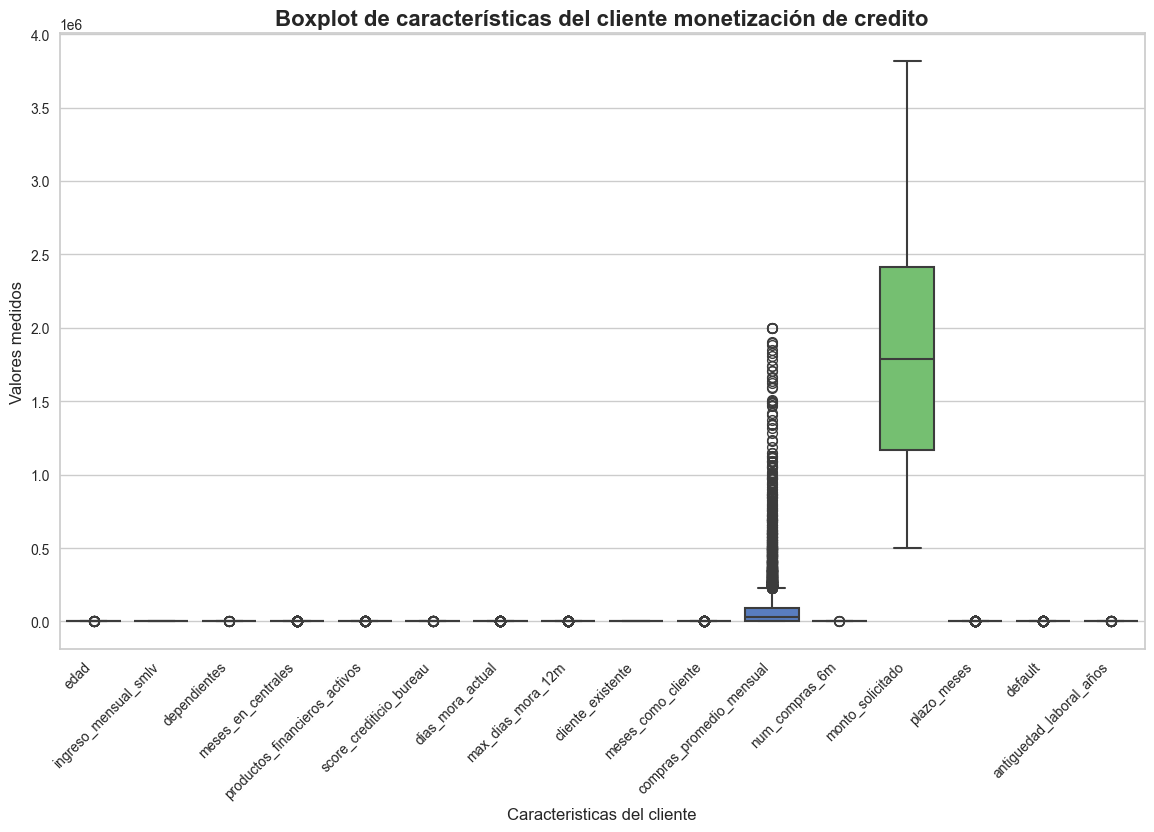

In [24]:
# Se seleccionan variables numéricas
train_numeric = df_model.select_dtypes(include=['float64', 'int64'])

# Se Configura tamaño y estilo
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Se realiza creación de Boxplot
sns.boxplot(data=train_numeric, palette="muted", linewidth=1.5)
plt.title("Boxplot de características del cliente monetización de credito", fontsize=16, fontweight='bold')
plt.xlabel("Caracteristicas del cliente", fontsize=12)
plt.ylabel("Valores medidos", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


Outliers en compras promedio mensuales se deben gestionar con detalle y cuidado para evitar sesgos

In [25]:
df_model.dtypes

customer_id                       object
edad                               int64
rango_edad                        object
genero                            object
estado_civil                      object
nivel_educativo                   object
ingreso_mensual_smlv             float64
tipo_empleo                       object
dependientes                       int64
tipo_vivienda                     object
meses_en_centrales                 int64
productos_financieros_activos      int64
score_crediticio_bureau            int64
dias_mora_actual                   int64
max_dias_mora_12m                  int64
cliente_existente                  int64
Tipo_de_cliente                   object
meses_como_cliente                 int64
compras_promedio_mensual           int64
num_compras_6m                     int64
categoria_principal               object
canal_aplicacion                  object
monto_solicitado                   int64
plazo_meses                        int64
default         

### comportamiento de caracteris

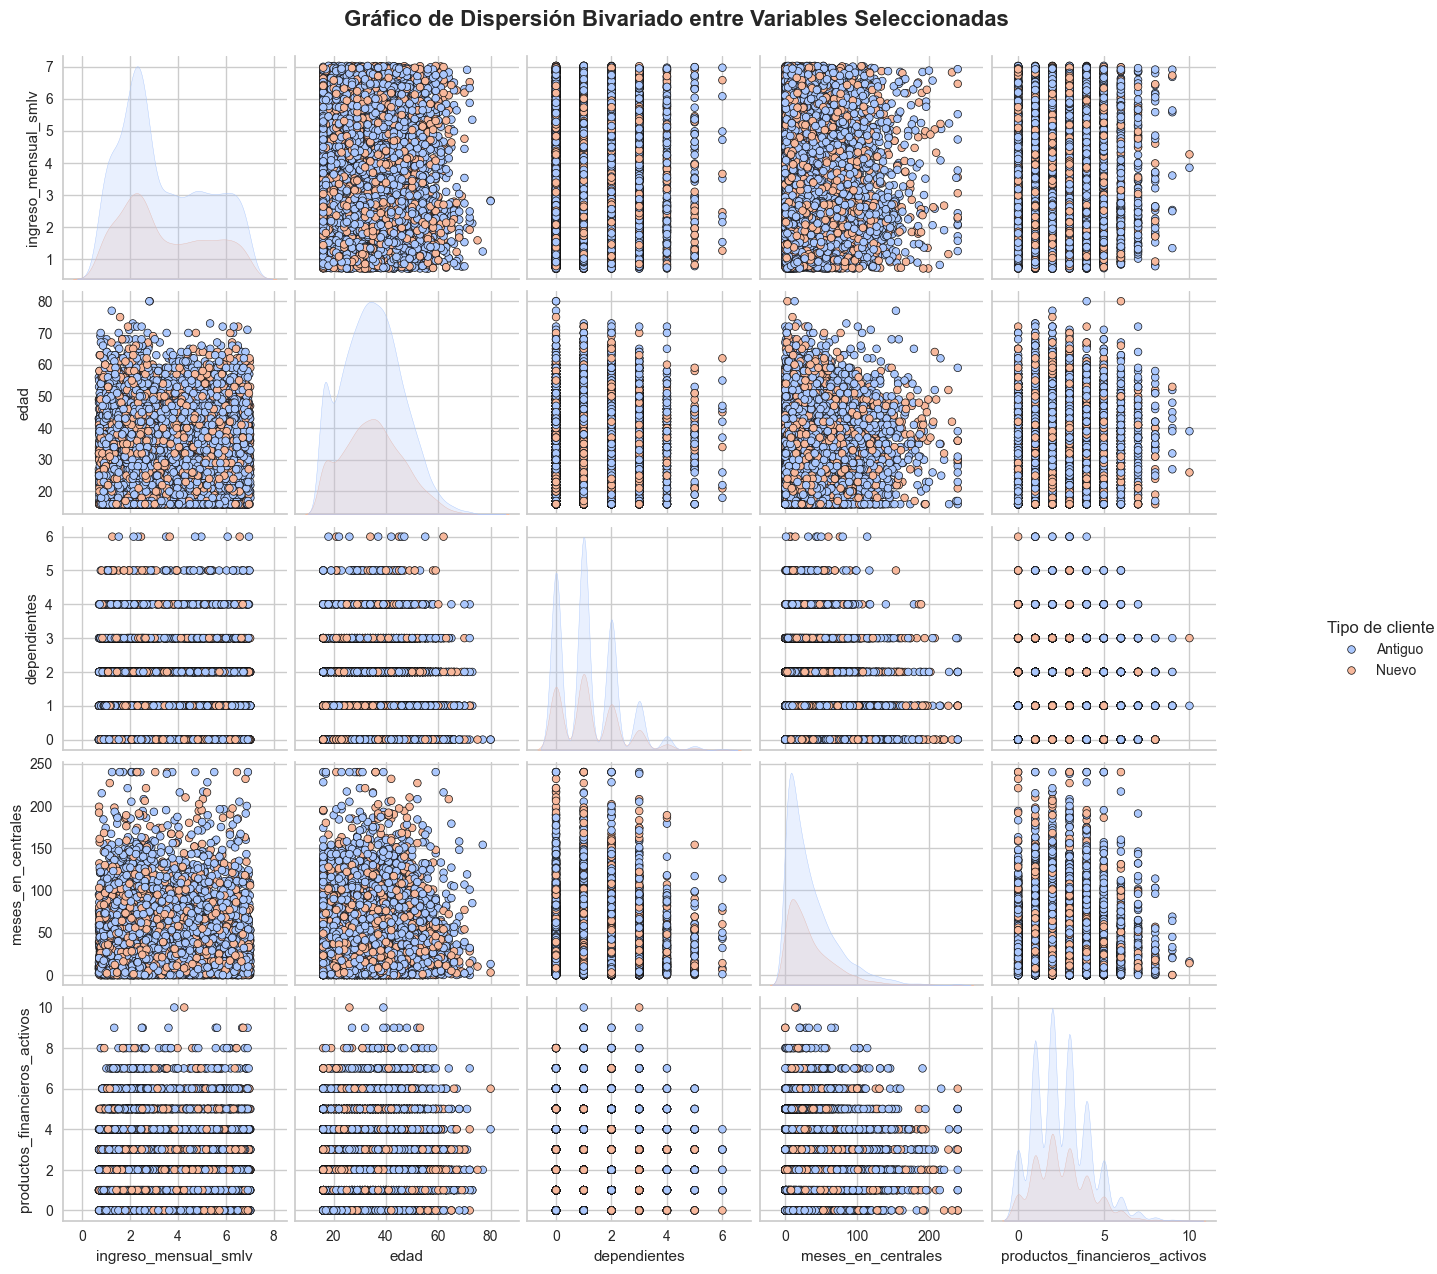

In [26]:
# Selección de las 4 variables para el gráfico bivariado
variables = ['ingreso_mensual_smlv', 'edad','dependientes', 'meses_en_centrales',
'productos_financieros_activos']

# Crear PairPlot con las variables seleccionadas
g = sns.pairplot(
    data=df_model,
    vars=variables,
    hue='Tipo_de_cliente',
    palette='coolwarm',
    diag_kind='kde',
    plot_kws={'s': 30, 'edgecolor': 'k', 'linewidth': 0.5}
)


# Ajustes del título
g.fig.suptitle('Gráfico de Dispersión Bivariado entre Variables Seleccionadas',
               fontsize=16, fontweight='bold', y=1.02)

# Ajustar la posición de la leyenda para evitar solapamientos
g._legend.set_title("Tipo de cliente")
g._legend.set_bbox_to_anchor((1.05, 0.5))

# Mostrar el gráfico
plt.show()

### Tinene mayor ingresos y edad los clientes antiguos de los Nuevos

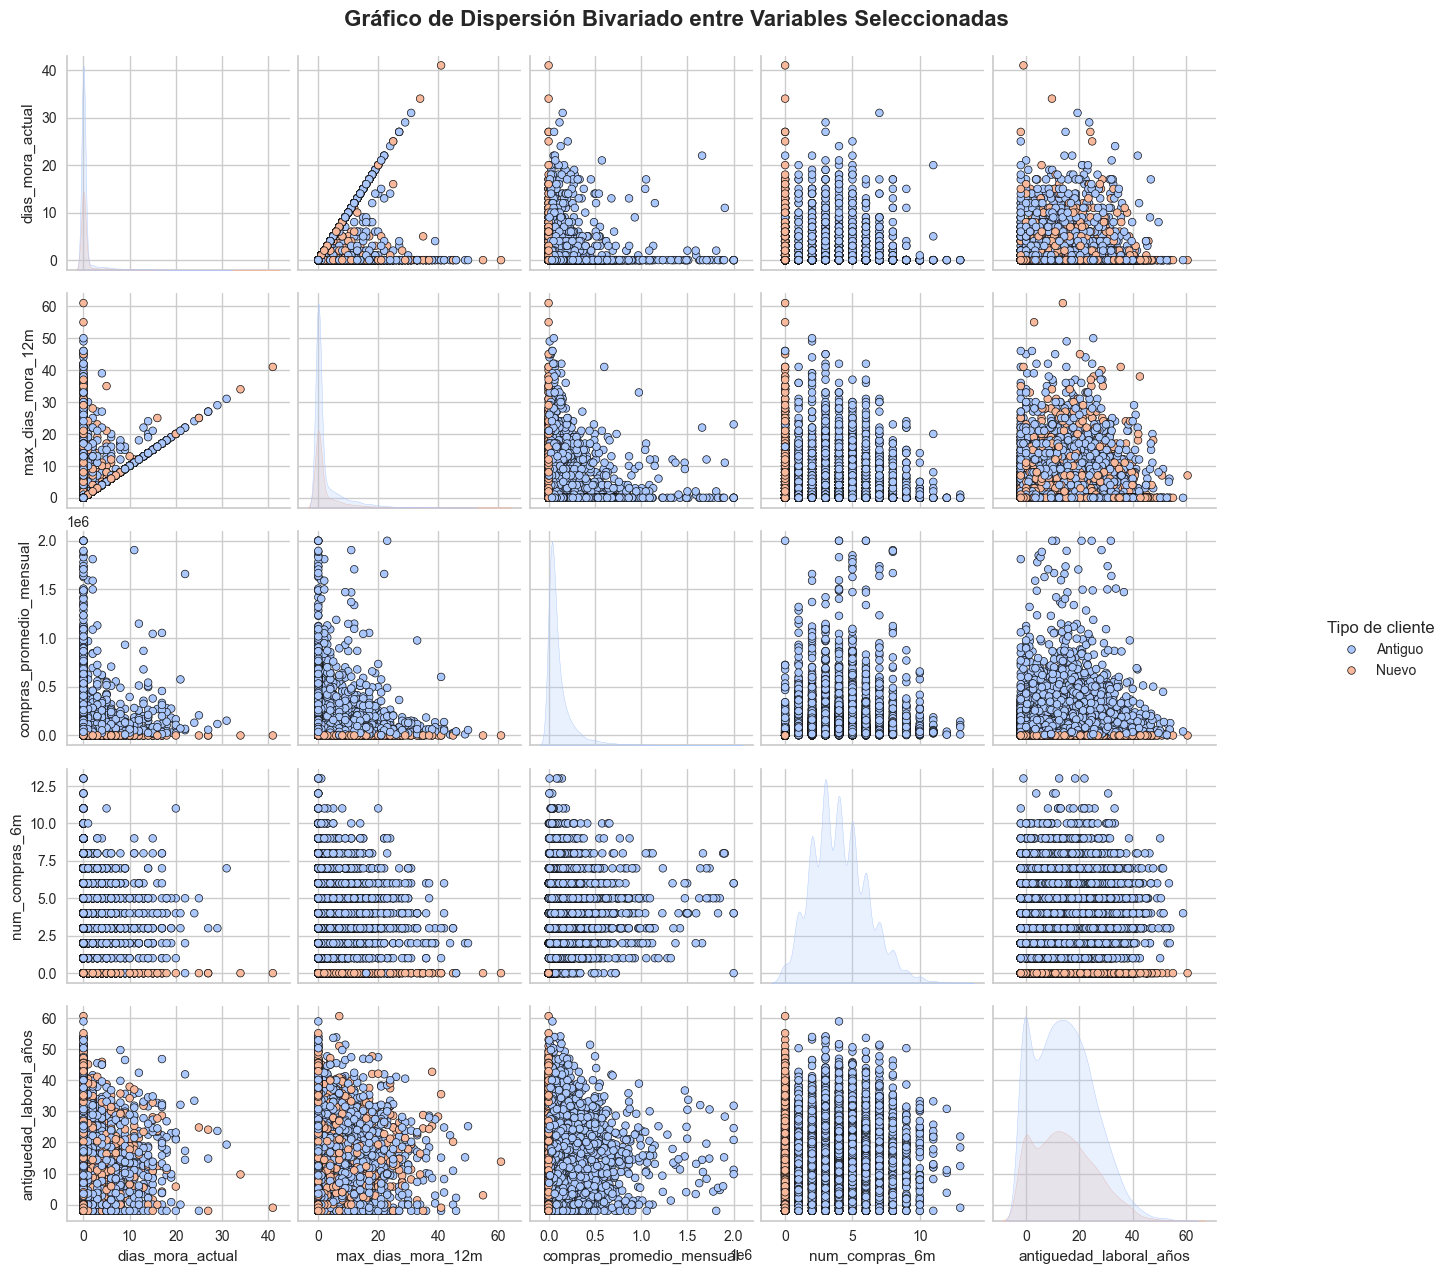

In [27]:
# Selección de las 4 variables para el gráfico bivariado
variables = ['dias_mora_actual', 'max_dias_mora_12m','compras_promedio_mensual', 'num_compras_6m','antiguedad_laboral_años']

# Crear PairPlot con las variables seleccionadas
g = sns.pairplot(
    data=df_model,
    vars=variables,
    hue='Tipo_de_cliente',
    palette='coolwarm',
    diag_kind='kde',
    plot_kws={'s': 30, 'edgecolor': 'k', 'linewidth': 0.5}
)


# Ajustes del título
g.fig.suptitle('Gráfico de Dispersión Bivariado entre Variables Seleccionadas',
               fontsize=16, fontweight='bold', y=1.02)

# Ajustar la posición de la leyenda para evitar solapamientos
g._legend.set_title("Tipo de cliente")
g._legend.set_bbox_to_anchor((1.05, 0.5))

# Mostrar el gráfico
plt.show()

### La antiguedad laboral en años es mayor en los clientes antiguos que en los nuevos

#### Análisis de Correlación de variables

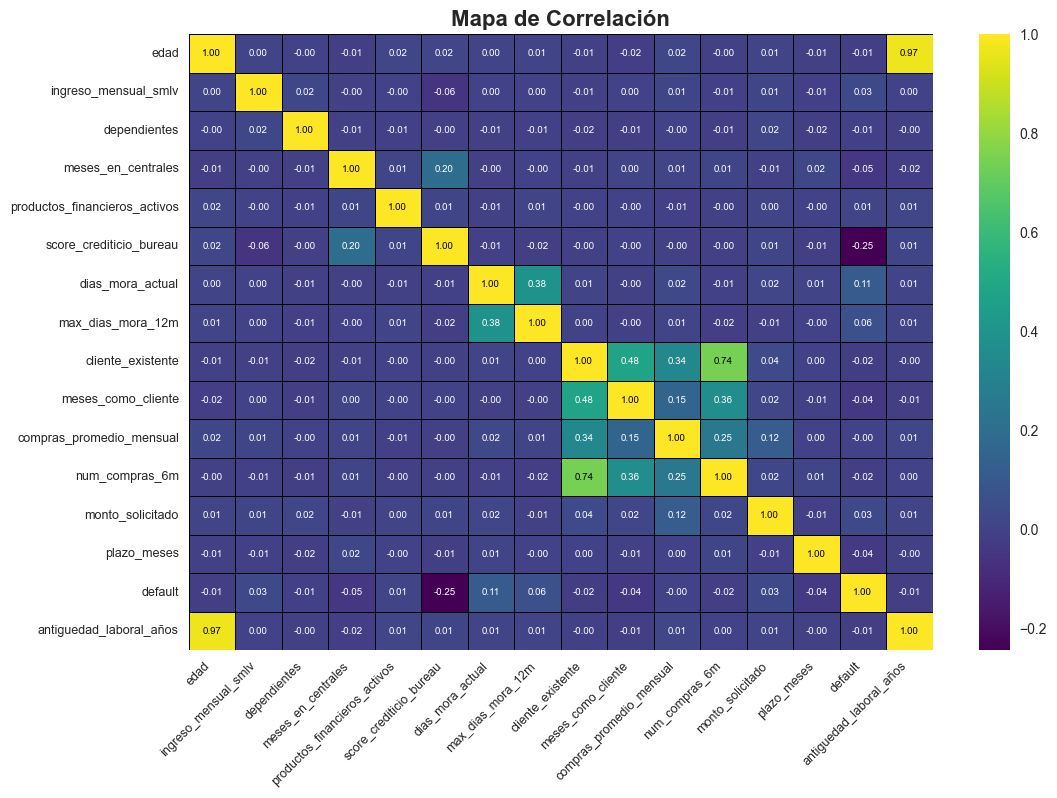

In [28]:
# Filtrar solo columnas numéricas y calcular la matriz de correlación
numeric_columns = df_model.select_dtypes(include=['number'])
corr_matrix = numeric_columns.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Crear el mapa de calor con la paleta 'viridis'
heatmap = sns.heatmap(
    corr_matrix,
    cmap='viridis',  # Paleta vibrante
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    linecolor='black',
    cbar=True,
    annot_kws={"size": 7}  # Ajuste del tamaño del texto
)

# Ajustar el color del texto para mayor legibilidad
for text in heatmap.texts:
    val = float(text.get_text())
    text.set_color('white' if val < 0.5 else 'black')  # Texto blanco para valores bajos y negro para altos

# Añadir título y ajustes de ejes
plt.title('Mapa de Correlación', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

# Mostrar el gráfico
plt.show()


#### 2.1 AutoML pre modelamiento

In [29]:
df_model.dtypes

customer_id                       object
edad                               int64
rango_edad                        object
genero                            object
estado_civil                      object
nivel_educativo                   object
ingreso_mensual_smlv             float64
tipo_empleo                       object
dependientes                       int64
tipo_vivienda                     object
meses_en_centrales                 int64
productos_financieros_activos      int64
score_crediticio_bureau            int64
dias_mora_actual                   int64
max_dias_mora_12m                  int64
cliente_existente                  int64
Tipo_de_cliente                   object
meses_como_cliente                 int64
compras_promedio_mensual           int64
num_compras_6m                     int64
categoria_principal               object
canal_aplicacion                  object
monto_solicitado                   int64
plazo_meses                        int64
default         

In [30]:
df_model.select_dtypes(include= ['float64','int64']).columns

Index(['edad', 'ingreso_mensual_smlv', 'dependientes', 'meses_en_centrales',
       'productos_financieros_activos', 'score_crediticio_bureau',
       'dias_mora_actual', 'max_dias_mora_12m', 'cliente_existente',
       'meses_como_cliente', 'compras_promedio_mensual', 'num_compras_6m',
       'monto_solicitado', 'plazo_meses', 'default',
       'antiguedad_laboral_años'],
      dtype='object')

In [31]:
df_model.select_dtypes(include= ['object']).columns

Index(['customer_id', 'rango_edad', 'genero', 'estado_civil',
       'nivel_educativo', 'tipo_empleo', 'tipo_vivienda', 'Tipo_de_cliente',
       'categoria_principal', 'canal_aplicacion'],
      dtype='object')

In [32]:
ClassificationExperiment = ClassificationExperiment() # instanciamos un objeto de la clase

numerical_features = list(df_model.select_dtypes(include= ['float64','int64']).columns)
numerical_features.remove('edad')
numerical_features.remove('monto_solicitado')
numerical_features.remove('plazo_meses')
numerical_features.remove('default')
categorical_features = list(df_model.select_dtypes(include= ['object']).columns)
categorical_features.remove('Tipo_de_cliente')
categorical_features.remove('customer_id')


In [33]:
numerical_features

['ingreso_mensual_smlv',
 'dependientes',
 'meses_en_centrales',
 'productos_financieros_activos',
 'score_crediticio_bureau',
 'dias_mora_actual',
 'max_dias_mora_12m',
 'cliente_existente',
 'meses_como_cliente',
 'compras_promedio_mensual',
 'num_compras_6m',
 'antiguedad_laboral_años']

In [34]:
categorical_features

['rango_edad',
 'genero',
 'estado_civil',
 'nivel_educativo',
 'tipo_empleo',
 'tipo_vivienda',
 'categoria_principal',
 'canal_aplicacion']

In [35]:
df_model.dtypes

customer_id                       object
edad                               int64
rango_edad                        object
genero                            object
estado_civil                      object
nivel_educativo                   object
ingreso_mensual_smlv             float64
tipo_empleo                       object
dependientes                       int64
tipo_vivienda                     object
meses_en_centrales                 int64
productos_financieros_activos      int64
score_crediticio_bureau            int64
dias_mora_actual                   int64
max_dias_mora_12m                  int64
cliente_existente                  int64
Tipo_de_cliente                   object
meses_como_cliente                 int64
compras_promedio_mensual           int64
num_compras_6m                     int64
categoria_principal               object
canal_aplicacion                  object
monto_solicitado                   int64
plazo_meses                        int64
default         

In [37]:
print(df_model['default'].value_counts(dropna=False))
print()
print(df_model['default'].value_counts(True,dropna=False)*100)

default
0    8450
1    1550
Name: count, dtype: int64

default
0   84.50000
1   15.50000
Name: proportion, dtype: float64


In [38]:
1550*2

3100

### 3. Configuración de pipeline (transformación, imputación, selección de variables…)

In [36]:
# Inicializamos el 'setup' sobre el objeto de clase 'ClassificationExperiment'
ClassificationExperiment.setup(data=df_model, 
                               target='default',
                               train_size=0.8,
                            #    ordinal_features={'arquetipo':['DURMIENTE','TRADICIONAL','TEMEROSO','INDECISO','MULTICANAL','GEEK']}, # default: None, lista de categorical features a ser codificadas ordinalmente (siguiendo relacion de orden). 
                           #     #i.e categorical feature 'low','medium','high'; donde low < medium < high, debe pasarse como: ordinal_features={'col_name':['low','medium','high']}
                               numeric_features= numerical_features, # default: None: son inferidas, sino toma una lista de string con el nombre de las columnas numericas.
                               categorical_features= categorical_features, # default: None: son inferidas, sino toma una lista de string con el nombre de las columnas categoricas.
                               ignore_features=['customer_id','edad','Tipo_de_cliente','monto_solicitado','plazo_meses'], # default: None, Lista con features a ignorar durante el preprocesamiento y entrenamiento de modelos.
                               preprocess=True, # default: True, cuando False no se aplican transformaciones y los datos deben estar listos para el modelado (sin NaN, sin fechas, sin strings).
                               numeric_imputation='median', # default: 'mean', estrategia para imputar missing values en las numerical features. 
                           #     #'mean', 'drop': elimina las filas con missing values, 'median', 'mode', 'knn': imputa usando una aproximacion K-Nearest Neighbors,
                           #     # int or float: imputa con un valor numerico. 
                               categorical_imputation='mode', # default: 'mode', estrategia para imputar missing values en las categorical features. 
                           #     #'mode', 'drop': elimina las filas con missing values, str: imputa con un string ingresado.
                                max_encoding_ohe=25, # default: 25, entero para establecer el numero maximo de categorias unicas que puede tener una categorical 
                           #  #    #feature para usar one hot encoding, si tiene mas de 25 categorias se codifica con TargetEncoder.
                           #  #    encoding_method = None # category-encoders estimator, default = None.
                                   #A category-encoders estimator to encode the categorical columns with more than max_encoding_ohe unique values. If None, category_encoders.target_encoder.TargetEncoder is used.
                               rare_to_value=0.001, # default: None, fraccion minima de categorias en una columna para consiferar rara. si una categoria
                               #tiene menos del 0.1% de los datos esta categoria sera reemplazada por rare_value.
                               rare_value='rare', #default: 'rare', valor con el cual se reemplazan las categorias raras,
                               remove_multicollinearity=True, # default: False, cuando True las features con alta correlacion definida son removidas.
                               multicollinearity_threshold=0.8, #default: 0.9, correlacion de Pearson minima absoluta para identificar features correlacionadas.
                               remove_outliers=True, # defalut: False, cuando True se remueven los outliers del set training usando Isolation Forest.
                               outliers_method='iforest', # default: 'iforest', metodo para remover outliers. los metodos:
                           #  #    #'iforest': usa sklearn IsolationForest, 'ee': sklearn EllipticEnvelope, 'lof': sklearn LocalOutlierFactor
                               outliers_threshold=0.05, # default: 0.05, porcentaje de outliers a ser removido del dataset.
                               fix_imbalance=True, # default: False, True cuando la distribucion del target es desbalanceada
                               fix_imbalance_method='RandomUnderSampler', # default: 'SMOTE', metodo para balancear la distribucion del target. Elegir un metodo de imblearn.
                           #  #    #'SMOTE': over-sampling, 'RandomUnderSampler': under-sampling....
                           #  #    transformation=False, # default: False, cuando es True aplica una transformacion de potencias para que datos distribuyan Gaussian
                           #  #    transformation_method='yeo-johnson', # default: 'yeo-johnson', se define el metodo de transformacion Gaussiana. 'yeo-johnson', 'quantile'
                           #  #    normalize=False, # default: False, True para transformar las features por un metodo de escalado, definido en normalize_method
                           #  #    normalize_method='zscore', # default: 'zscore', metodo de transformacion para escalado de features. 'zscore', 'minmax'
                               #feature_selection=True, # default: False, cuando True selecciona un subconjunto de features en funcion de un puntaje de importancia 
                               #determinado por feature_selection_estimator
                               #feature_selection_method='univariate', # default: 'classic', 'classic': usa sklearn SelectFromModel, 'univariate': usa sklearn SelectKBest, 'sequential': usa sklearn SequentialFeatureSelector
                               #feature_selection_estimator='lightgbm', # str o sklearn estimator, default:'lightgbm'. classifier usado para determinar feature importances. El estimator debe tener feature_importances_ or coef_ despues de fittear. Si no usa 'LGBMClassifier'.
                               data_split_stratify=True, # se estratifica segun Target durante el train_test_split
                               fold_strategy='stratifiedkfold', # durante el Cross-Validation se hace el split estratificadamente 
                               fold=10, # cantidad de folds para el C-V
                               session_id=42, # se usa para inicializar las semillas de todos los procesos
                               #profile=True # default: False, cuando True un reporte interactivo EDA es mostrado. No funciona.
                               )

### data train modelo

In [39]:
ClassificationExperiment.get_config() # para mostrar a todas las opciones que puedo acceder luego del setup

data_process = ClassificationExperiment.get_config('dataset_transformed')
data_process.head()

rango_edad_Menores de edad  rango_edad_Generación X (40-54)  \
1264                     0.00000                          0.00000   
3430                     0.00000                          1.00000   
642                      0.00000                          0.00000   
1945                     0.00000                          0.00000   
5060                     0.00000                          0.00000   

      rango_edad_Millennials (24-39)  rango_edad_Baby Boomer (>55)  \
1264                         1.00000                       0.00000   
3430                         0.00000                       0.00000   
642                          1.00000                       0.00000   
1945                         1.00000                       0.00000   
5060                         1.00000                       0.00000   

      rango_edad_Centenials (18-23)  genero_F  genero_M  genero_O  \
1264                        0.00000   0.00000   1.00000   0.00000   
3430                        0.00000   0.00000   1.00000   0.00000   
642                         0.00000   0.00000   1.00000   0.00000   
1945                        0.00000   1.00000   0.00000   0.00000   
5060                        0.00000   1.00000   0.00000   0.00000   

      estado_civil_Casado  estado_civil_Soltero  estado_civil_Divorciado  \
1264              0.00000               1.00000                  0.00000   
3430              1.00000               0.00000                  0.00000   
642               0.00000               1.00000                  0.00000   
1945              1.00000               0.00000                  0.00000   
5060              0.00000               1.00000                  0.00000   

      estado_civil_Viudo  nivel_educativo_Secundaria  \
1264             0.00000                     0.00000   
3430             0.00000                     0.00000   
642              0.00000                     0.00000   
1945             0.00000                     0.00000   
5060             0.00000                     0.00000   

      nivel_educativo_Posgrado  nivel_educativo_Universitario  \
1264                   0.00000                        1.00000   
3430                   0.00000                        0.00000   
642                    0.00000                        1.00000   
1945                   0.00000                        0.00000   
5060                   0.00000                        0.00000   

      nivel_educativo_Técnico  nivel_educativo_Primaria  ingreso_mensual_smlv  \
1264                  0.00000                   0.00000               1.72038   
3430                  1.00000                   0.00000               5.88923   
642                   0.00000                   0.00000               1.03712   
1945                  1.00000                   0.00000               6.04697   
5060                  1.00000                   0.00000               4.66385   

      tipo_empleo_Empleado  tipo_empleo_Independiente  tipo_empleo_Pensionado  \
1264               1.00000                    0.00000                 0.00000   
3430               1.00000                    0.00000                 0.00000   
642                1.00000                    0.00000                 0.00000   
1945               1.00000                    0.00000                 0.00000   
5060               1.00000                    0.00000                 0.00000   

      dependientes  tipo_vivienda_Propia  tipo_vivienda_Familiar  \
1264       2.00000               1.00000                 0.00000   
3430       3.00000               1.00000                 0.00000   
642        0.00000               0.00000                 0.00000   
1945       1.00000               1.00000                 0.00000   
5060       2.00000               1.00000                 0.00000   

      tipo_vivienda_Arriendo  meses_en_centrales  \
1264                 0.00000            10.00000   
3430                 0.00000            46.00000   
642                  1.00000   

In [40]:
print(pd.DataFrame(ClassificationExperiment.get_config('y_train_transformed')).default.value_counts())
print()
print(pd.DataFrame(ClassificationExperiment.get_config('y_train_transformed')).default.value_counts(normalize=True))
print()
print(pd.DataFrame(ClassificationExperiment.get_config('y_test')).default.value_counts())
print()
print(pd.DataFrame(ClassificationExperiment.get_config('y_test')).default.value_counts(normalize=True))
print()

default
1    1155
0    1155
Name: count, dtype: int64

default
1   0.50000
0   0.50000
Name: proportion, dtype: float64

default
0    1690
1     310
Name: count, dtype: int64

default
0   0.84500
1   0.15500
Name: proportion, dtype: float64



In [41]:
print(pd.DataFrame(ClassificationExperiment.get_config('y_train_transformed')).default.value_counts(normalize=True))
print()
print(pd.DataFrame(ClassificationExperiment.get_config('y_test')).default.value_counts(normalize=True))
print()
ClassificationExperiment.get_config('pipeline')


default
1   0.50000
0   0.50000
Name: proportion, dtype: float64

default
0   0.84500
1   0.15500
Name: proportion, dtype: float64



Pipeline(memory=FastMemory(location=C:\Users\Daniel\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['ingreso_mensual_smlv',
                                             'dependientes',
                                             'meses_en_centrales',
                                             'productos_financieros_activos',
                                             'score_crediticio_bureau',
                                             'dias_mora_actual',
                                             'max_dias_mora_12m',
                                             'cliente_existente',
                                             'meses_como_cliente',
                                             'comp...
                                                               random_state=42,
                                                               threshold=0.05))),
                ('balance',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=FixImbalancer(estimator=RandomUnderSampler(random_state=42,
                                                                                           replacement=False,
                                                                                           sampling_strategy='auto')))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

### 4. Definición de modelos (cross-validation)

#### 5. Entrenamiento y selección de Modelos

In [42]:
# comparamos los diferentes modelos

# catboost no esta disponible, knn se demora mucho (no incluirlo)
MejorModelo = ClassificationExperiment.compare_models(sort='AUC',include=['lightgbm',
                                                                          'xgboost',
                                                                          'ada',
                                                                          'lr',
                                                                          'dt',
                                                                          'dummy',
                                                                          'nb',
                                                                          'rf',
                                                                          'qda',
                                                                          'lda',
                                                                          'svm',
                                                                          'ridge'])
# time: 9min

MejorModelo

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

### 5.1. Tuneo de hipérparametros

In [43]:
### Tuneo de Hiperparametros
MejorModelo_Tuneado = ClassificationExperiment.tune_model(estimator=MejorModelo,
                                                          optimize='AUC',
                                                          search_library='optuna',
                                                          search_algorithm='random' # default: 'tpe' (Tree-structured Parzen Estimator search). 'tpe', 'random'
                                                          )
# elapsed time: 18 min

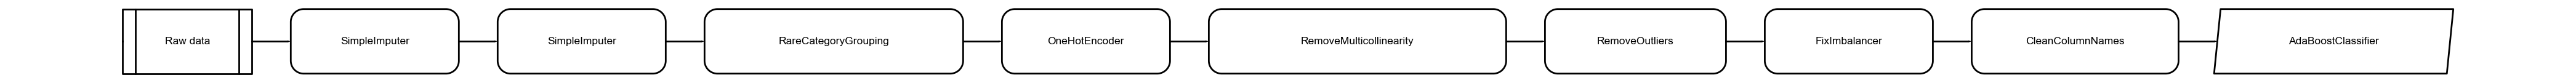

In [44]:
#### Graficas de rendimiento modelo
# plot pipeline
ClassificationExperiment.plot_model(estimator=MejorModelo,
                                    plot='pipeline'
                                    )


### 6. Interpretación de resultados (métricas ajustes, objetivo F1)

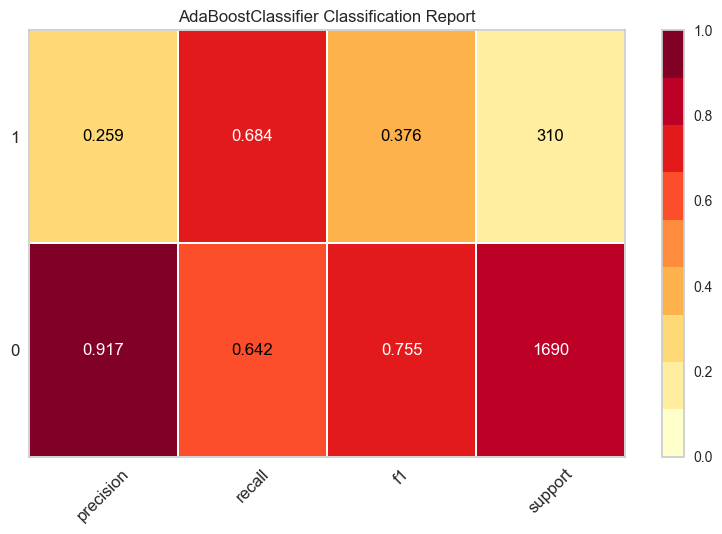

In [45]:
# plot class report
ClassificationExperiment.plot_model(estimator=MejorModelo,
                                    plot='class_report'
                                    #save=True # seguarda como 'Class Report.png'
                                    )

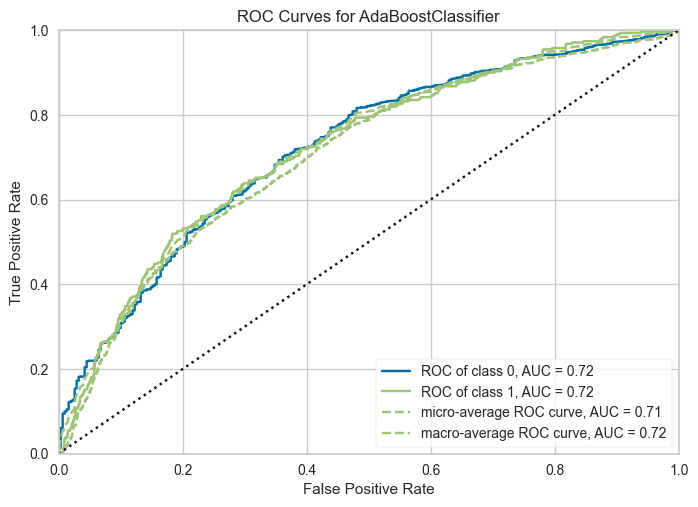

In [46]:
# plot ROC-AUC
ClassificationExperiment.plot_model(estimator=MejorModelo,
                                    plot='auc'
                                    )

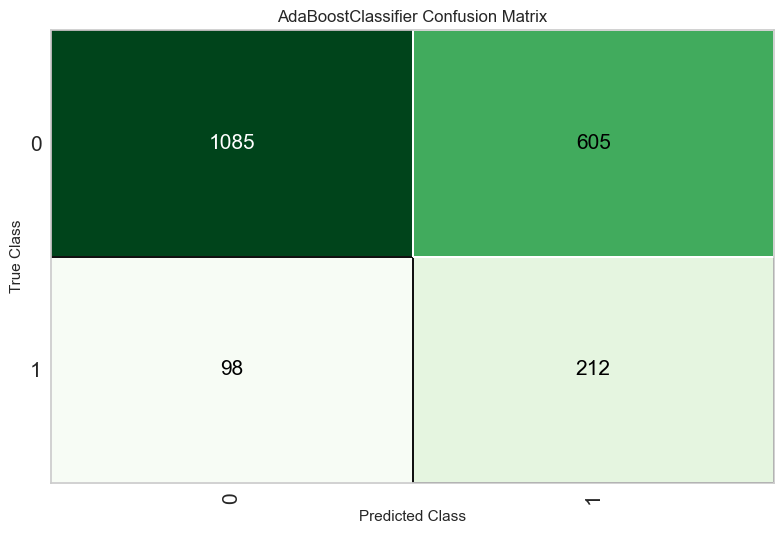

In [47]:
# plot confusion matrix
ClassificationExperiment.plot_model(estimator=MejorModelo,
                                    plot='confusion_matrix'
                                    )

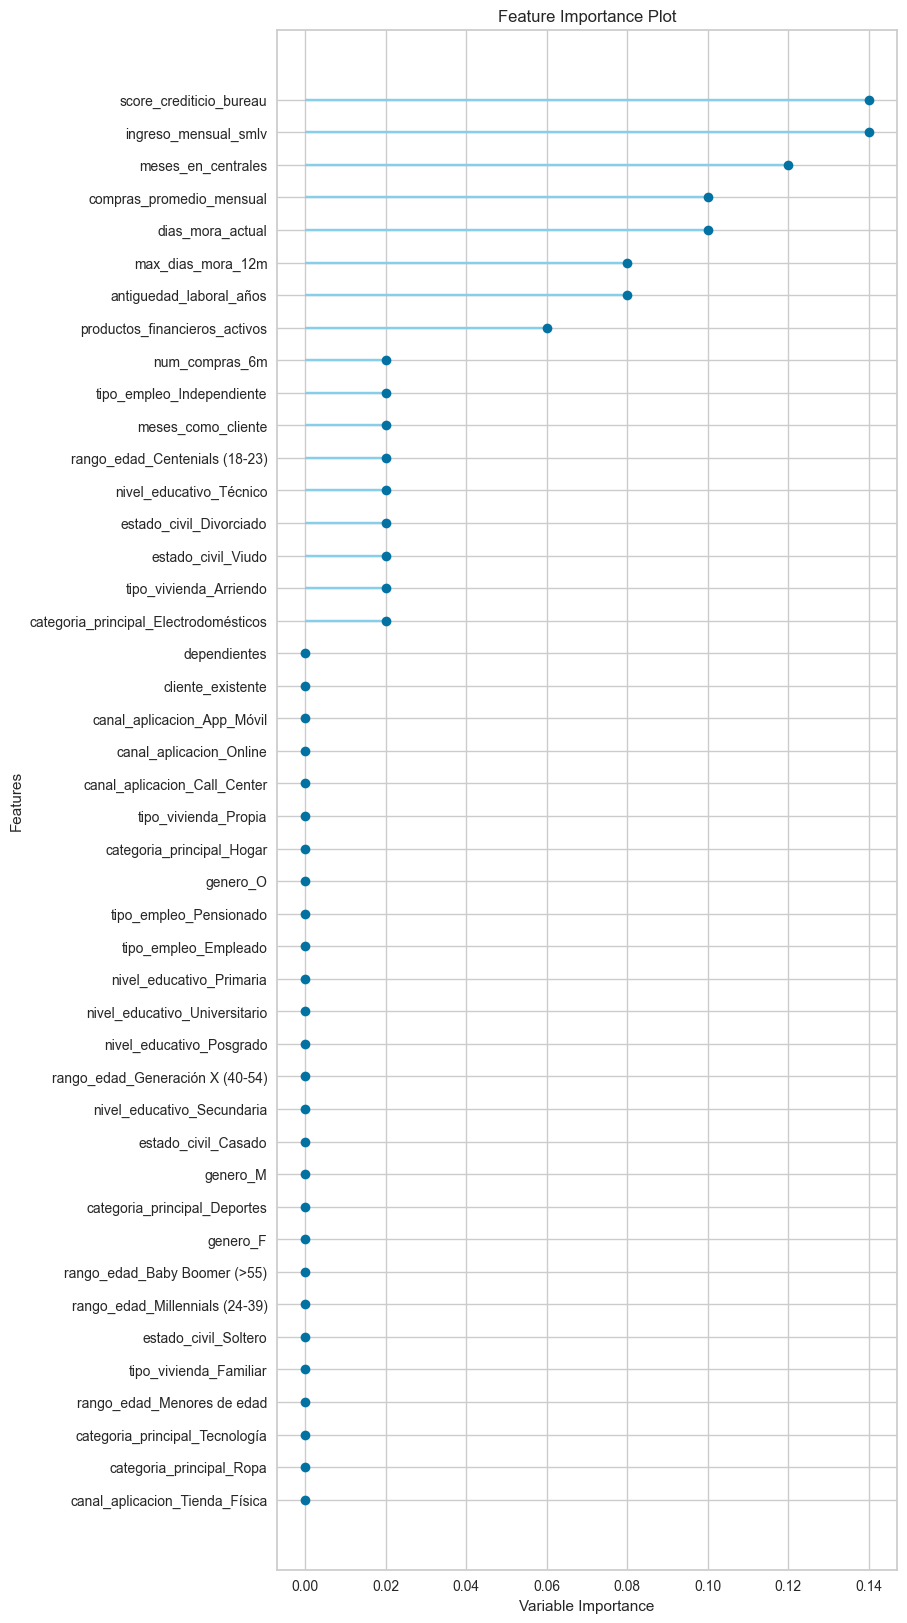

In [48]:
# plot features importance
ClassificationExperiment.plot_model(estimator=MejorModelo,
                                    plot='feature_all'
                                    )

In [52]:

# # interpret summary model, SHAP Values. No disponible para python 3.7
# ClassificationExperiment.interpret_model(estimator=MejorModelo,
#                                          plot='summary')


In [49]:
df_prueba = ClassificationExperiment.predict_model(estimator=MejorModelo,
                                                   raw_score=True # default: False, retorna la probabilidad a cada label i.e: label:0 score:1 significa probabilidad de 100% de ser 0. 
                                                   # Cuando True se retornan 2 columnas prediction_score_0	prediction_score_1, cada una con la probabilidad de ser cada etiqueta.
                                                   )


In [50]:
df_prueba.dtypes

rango_edad                       category
genero                           category
estado_civil                     category
nivel_educativo                  category
ingreso_mensual_smlv              float32
tipo_empleo                      category
dependientes                         int8
tipo_vivienda                    category
meses_en_centrales                  int32
productos_financieros_activos        int8
score_crediticio_bureau             int32
dias_mora_actual                     int8
max_dias_mora_12m                    int8
cliente_existente                    int8
meses_como_cliente                   int8
compras_promedio_mensual            int32
num_compras_6m                       int8
categoria_principal              category
canal_aplicacion                 category
antiguedad_laboral_años           float32
default                              int8
prediction_label                    int32
prediction_score_0                float64
prediction_score_1                

In [51]:
# Métricas
import matplotlib.pyplot as plt
#AUC
from sklearn.metrics import roc_auc_score

y_true = df_prueba['default']
y_pred = df_prueba['prediction_label']
y_pred_proba = df_prueba['prediction_score_1']

In [52]:
model = "Ada Boost Classifier"
metric = roc_auc_score(y_true, y_pred)
print(f'{model} AUC: {metric:0.4f}')
print("")

# Accuracy
from sklearn.metrics import accuracy_score

metric = accuracy_score( y_true, y_pred)
print(f'{model} Accuracy: {metric:0.4f}')

print("")


# Precision
from sklearn.metrics import precision_score

metric=precision_score( y_true, y_pred)
print(f'{model} Precision: {metric:0.4f}')
print("")

# Recall
from sklearn.metrics import recall_score

metric=recall_score( y_true, y_pred)
print(f'{model} recall: {metric:0.4f}')

print("")

# reporte de clasificacion
from sklearn.metrics import classification_report

print("reporte de clasificacion")
print(classification_report(y_true, y_pred))


Ada Boost Classifier AUC: 0.6629

Ada Boost Classifier Accuracy: 0.6485

Ada Boost Classifier Precision: 0.2595

Ada Boost Classifier recall: 0.6839

reporte de clasificacion
              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1690
           1       0.26      0.68      0.38       310

    accuracy                           0.65      2000
   macro avg       0.59      0.66      0.57      2000
weighted avg       0.82      0.65      0.70      2000




Matriz de Confusion Ada Boost Classifier



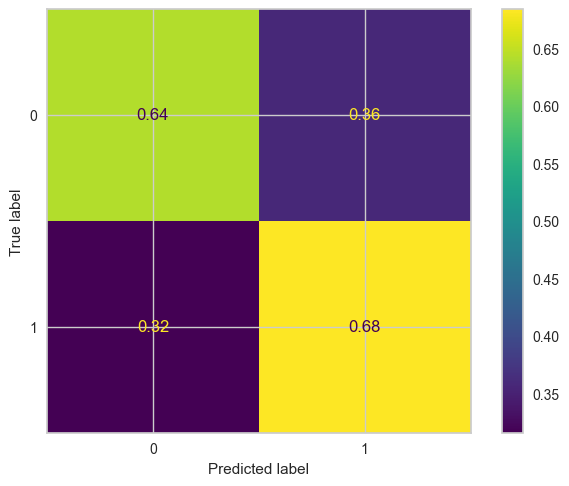

In [53]:
# Matriz de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("")
print("Matriz de Confusion Ada Boost Classifier")
print("")
cm = confusion_matrix(y_true, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [54]:
#### Comportamiento en deciles

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
warnings.simplefilter('ignore', (DeprecationWarning))

#### Comportamiento en deciles

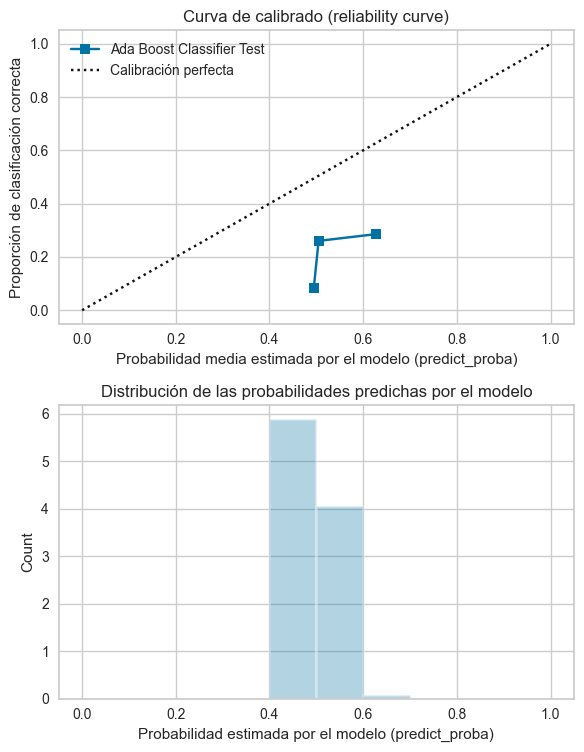

In [55]:

# Predicción con probabilidades
# ==============================================================================
# Se extraen las probabilidades de la clase positiva
prob_positivo = y_pred_proba
fraccion_positivos, media_prob_predicha = calibration_curve(y_true, prob_positivo, n_bins=20)

fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="Ada Boost Classifier Test")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(prob_positivo, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

In [56]:
# Distribucion de deciles
#deciles
def Deciles(y_proba):
    deci="D1,D2,D3,D4,D5,D6,D7,D8,D9,D10".split(",")
    interval_prob = ["[0,15)","[15,25)","[25,35)]","[35,45)","[45,55)","[55,65)","[65,75)","[75,80)","[80,85)","[85,100)"]

    D1 = len(y_proba[y_proba<0.1]) #cantidad de registros con probabilidad menor al 15% de ser 1
    D2 = len(y_proba[np.logical_and( y_proba>=0.1,y_proba<0.2)]) #cantidad registros con probobabilidad entre 15% y 25% de ser 1
    D3 = len(y_proba[np.logical_and( y_proba>=0.2,y_proba<0.3)]) #cantidad registros con probobabilidad entre 25% y 35% de ser 1
    D4 = len(y_proba[np.logical_and( y_proba>=0.3,y_proba<0.4)]) #cantidad registros con probobabilidad entre 35% y 45% de ser 1
    D5 = len(y_proba[np.logical_and( y_proba>=0.4,y_proba<0.5)]) #cantidad registros con probobabilidad entre 45% y 55% de ser 1
    D6 = len(y_proba[np.logical_and( y_proba>=0.5,y_proba<0.6)]) #cantidad registros con probobabilidad entre 55% y 65% de ser 1
    D7 = len(y_proba[np.logical_and( y_proba>=0.6,y_proba<0.7)]) #cantidad registros con probobabilidad entre 65% y 75% de ser 1
    D8 = len(y_proba[np.logical_and( y_proba>=0.7,y_proba<0.8)]) #cantidad registros con probobabilidad entre 75% y 80% de ser 1
    D9 = len(y_proba[np.logical_and( y_proba>=0.8,y_proba<0.9)]) #cantidad registros con probobabilidad entre 80% y 85% de ser 1
    D10 = len(y_proba[y_proba>=0.9]) #cantidad registros con probobabilidad al 85% de ser 1

    deciles=[D1,D2,D3,D4,D5,D6,D7,D8,D9,D10]
    deci="D1,D2,D3,D4,D5,D6,D7,D8,D9,D10".split(",")
    interval_prob = ["[0,10)","[10,20)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100]"]
    bars = ["#"*int(round((i/len(y_proba))*100,0)) for i in deciles]

    return {"Decil":deci, "Intervalo de Probabilidad [%]":interval_prob,"Cantidad de registros":deciles, "Barras":bars}


## Cutoff: punto de corte probabilístico:

Encontrar el punto de corte de la probabilidad donde maximicemos especificidad y minimizamos la sensibilidad.

╒═════════╤═════════════════════════════════╤═════════════════════════╤═════════════════════════════════════════════════════════════╕
│ Decil   │ Intervalo de Probabilidad [%]   │   Cantidad de registros │ Barras                                                      │
╞═════════╪═════════════════════════════════╪═════════════════════════╪═════════════════════════════════════════════════════════════╡
│ D1      │ [0,10)                          │                       0 │                                                             │
├─────────┼─────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────────────────┤
│ D2      │ [10,20)                         │                       0 │                                                             │
├─────────┼─────────────────────────────────┼─────────────────────────┼─────────────────────────────────────────────────────────────┤
│ D3      │ [20,30)                         │                 

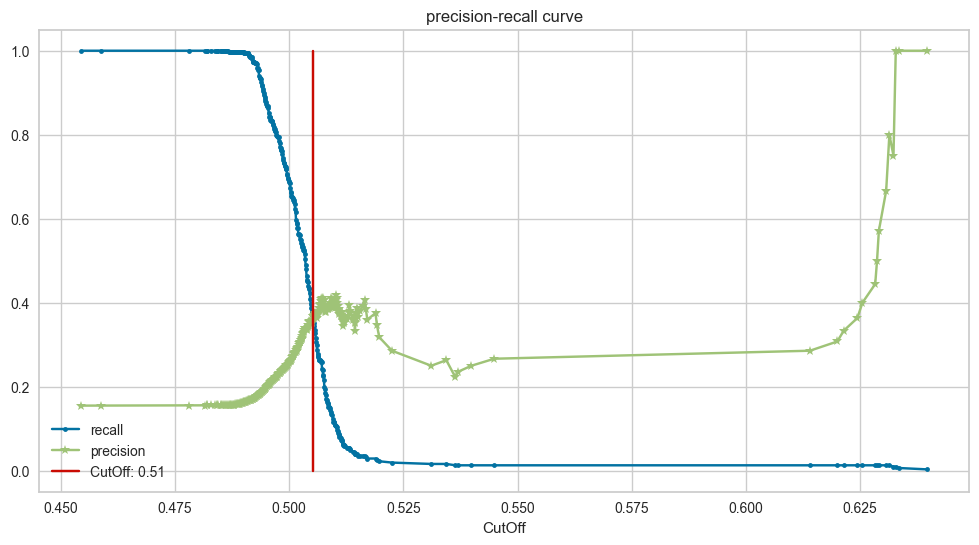

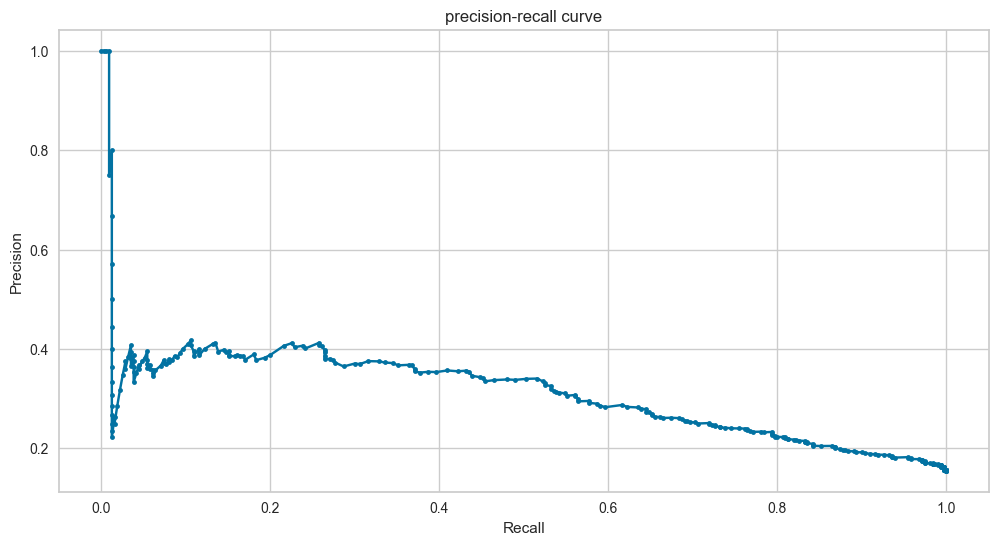

In [57]:
from tabulate import tabulate

print(tabulate( Deciles(y_pred_proba),headers="keys", tablefmt="fancy_grid"))

from sklearn.metrics import precision_recall_curve

y_true = df_prueba['default']
y_pred = df_prueba['prediction_label']
y_pred_proba = df_prueba['prediction_score_1']

precision, recall, thresholds_pr = precision_recall_curve(y_true.values,y_pred_proba.values)

diff = np.abs(recall-precision)

argmin = np.argmin(diff)
# graficar la curva precision-recall

plt.rcParams.update({'font.size':30})

plt.figure(figsize=(12,6),dpi=100)
plt.plot(thresholds_pr,recall[:-1], marker='.',label='recall')
plt.plot(thresholds_pr,precision[:-1], marker='*',label='precision')
plt.plot([thresholds_pr[argmin],thresholds_pr[argmin]], [0,1], 'r', label='CutOff: '+str(round(thresholds_pr[argmin],2)))
plt.xlabel('CutOff')
plt.title('precision-recall curve')
plt.legend()
plt.show()

plt.figure(figsize=(12,6),dpi=100)
plt.plot(recall,precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision-recall curve')
plt.show()

In [58]:
ClassificationExperiment.save_model(model=MejorModelo, model_name='AutoML_Model_pob_score_crediticio')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['ingreso_mensual_smlv',
                                              'dependientes',
                                              'meses_en_centrales',
                                              'productos_financieros_activos',
                                              'score_crediticio_bureau',
                                              'dias_mora_actual',
                                              'max_dias_mora_12m',
                                              'cliente_existente',
                                              'meses_como_cliente',
                                              'compras_promedio_mensual',
                                              'num_compras_6m',
                                              'a...
                                     transformer=FixImbalanc

#### Metodo tradicional

In [60]:
df_model.dtypes

customer_id                       object
edad                               int64
rango_edad                        object
genero                            object
estado_civil                      object
nivel_educativo                   object
ingreso_mensual_smlv             float64
tipo_empleo                       object
dependientes                       int64
tipo_vivienda                     object
meses_en_centrales                 int64
productos_financieros_activos      int64
score_crediticio_bureau            int64
dias_mora_actual                   int64
max_dias_mora_12m                  int64
cliente_existente                  int64
Tipo_de_cliente                   object
meses_como_cliente                 int64
compras_promedio_mensual           int64
num_compras_6m                     int64
categoria_principal               object
canal_aplicacion                  object
monto_solicitado                   int64
plazo_meses                        int64
default         

In [61]:
df_model_2= df_model[['default','rango_edad','genero', 'estado_civil','nivel_educativo','tipo_empleo',
 'tipo_vivienda','categoria_principal','canal_aplicacion','ingreso_mensual_smlv',
 'dependientes','meses_en_centrales', 'productos_financieros_activos','score_crediticio_bureau',
 'dias_mora_actual','max_dias_mora_12m','cliente_existente', 'meses_como_cliente', 'compras_promedio_mensual', 'num_compras_6m','antiguedad_laboral_años']]

print(df_model_2.shape)
df_model_2.head()

(10000, 21)


default            rango_edad genero estado_civil nivel_educativo  \
0        0  Generación X (40-54)      M      Soltero      Secundaria   
1        0   Millennials (24-39)      M      Soltero   Universitario   
2        0  Generación X (40-54)      M       Casado      Secundaria   
3        0  Generación X (40-54)      M       Casado         Técnico   
4        1   Millennials (24-39)      F      Soltero         Técnico   

     tipo_empleo tipo_vivienda categoria_principal canal_aplicacion  \
0  Independiente      Arriendo          Tecnología    Tienda_Física   
1       Empleado      Familiar            Deportes           Online   
2  Independiente        Propia                Ropa    Tienda_Física   
3       Empleado      Arriendo               Hogar    Tienda_Física   
4       Empleado      Arriendo            Deportes           Online   

   ingreso_mensual_smlv  ...  meses_en_centrales  \
0               2.99289  ...                   0   
1               0.90866  ...                 146   
2               4.64025  ...                   9   
3               5.93632  ...                  19   
4               5.15615  ...                  35   

   productos_financieros_activos  score_crediticio_bureau  dias_mora_actual  \
0                              3                      677                 0   
1                              4                      683                 0   
2                              0                      533                 0   
3                              0                      750                 0   
4                              3                      666                 0   

   max_dias_mora_12m  cliente_existente  meses_como_cliente  \
0                  0                  1                   4   
1                  1                  0                   0   
2                  0                  1                  95   
3                  0                  1                  17   
4                  0                  0                   0   

   compras_promedio_mensual  num_compras_6m  antiguedad_laboral_años  
0                    343847               5                 20.50000  
1                         0               0                 13.40000  
2                     29590               2                 18.20000  
3                     21608               4                 34.40000  
4                         0               0                 10.90000  

[5 rows x 21 columns]

In [62]:
df_model_2.reset_index(inplace=True)
df_model_2.shape

(10000, 22)

In [63]:
types = pd.DataFrame(df_model_2.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int64      12
float64     2
object      8
dtype: int64


In [64]:
numeric_columns = list(set(types.index[types[0] !="O"].values))#-set(['y'])
df_rev_atipicos = df_model_2[numeric_columns]
print(df_rev_atipicos.shape)
df_rev_atipicos

(10000, 14)


dependientes  meses_en_centrales  meses_como_cliente  index  \
0                1                   0                   4      0   
1                1                 146                   0      1   
2                0                   9                  95      2   
3                1                  19                  17      3   
4                1                  35                   0      4   
...            ...                 ...                 ...    ...   
9995             3                  56                   5   9995   
9996             0                  23                   0   9996   
9997             6                  50                   0   9997   
9998             5                  11                   0   9998   
9999             0                  62                   2   9999   

      score_crediticio_bureau  productos_financieros_activos  default  \
0                         677                              3        0   
1                         683                              4        0   
2                         533                              0        0   
3                         750                              0        0   
4                         666                              3        1   
...                       ...                            ...      ...   
9995                      737                              4        0   
9996                      675                              3        0   
9997                      711                              3        0   
9998                      545                              3        1   
9999                      685                              4        0   

      max_dias_mora_12m  compras_promedio_mensual  antiguedad_laboral_años  \
0                     0                    343847                 20.50000   
1                     1                         0                 13.40000   
2                     0                     29590                 18.20000   
3                     0                     21608                 34.40000   
4                     0                         0                 10.90000   
...                 ...                       ...                      ...   
9995                  0                     13920                 25.20000   
9996                  0                         0                 -2.00000   
9997                  0                     66655                  3.50000   
9998                  2                         0                 14.40000   
9999                  0                     36542                 17.10000   

      num_compras_6m  ingreso_mensual_smlv  dias_mora_actual  \
0                  5               2.99289                 0   
1                  0               0.90866                 0   
2                  2               4.64025                 0   
3                  4               5.93632                 0   
4                  0               5.15615                 0   
...              ...                   ...               ...   
9995               3               5.63048                 0   
9996               0               6.39926                 0   
9997               4               1.53230                 0   
9998               0               3.95128                 2   
9999               5               2.46180                 0   

      cliente_existente  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  
...                 ...  
9995                  1  
9996                  0  
9997                  1  
9998                  0  
9999                  1  

[10000 rows x 14 columns]

In [65]:
%%time
# eliminacion de outliers en variables numericas

from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from scipy.linalg import inv

### la variable de entrada Data, es un DataFrame sin valores nulos, con solo variables numéricas no categóricas
### y sin la variable objetivo

# Cuando Outlier = True la funcion devuelve Data con los valores outliers encontrados en el conjunto de datos
# Cuando Outlier = False La función devuelve Data sin los valores outliers
def Mahalanobis(Data, Outlier=True):
    data = Data.copy()
    
    Mean = np.mean(data, axis=0)
    Cov_Inv = inv(np.cov(data.values.T))
    
    Mahala = []
    for i in range(len(data)):
        Mahala.append(mahalanobis(data.loc[i], Mean, Cov_Inv))
    
    data["Mahalanobis"] = Mahala
    data["p_value"] = 1 - chi2.cdf(data['Mahalanobis'], len(data.columns)-2)
    
    if Outlier:
        return data.loc[data.p_value < 0.01] #DataFrame solo con los valores outliers encontrados
    else:
        return data.loc[~(data.p_value < 0.01)] #DataFrame sin los valores outliers encontrados


data_sin_outliers = Mahalanobis(df_rev_atipicos, Outlier=False) # DataFrame sin los valores outliers encontrados en el conjunto de datos
#Outliers = Mahalanobis(df_rev_atipicos) # DataFrame con los valores outliers encontrados en el conjunto de datos
print("######################################################### \n")
print("Registros base original: ",len(df_rev_atipicos))
print("Registros base sin Outliers: ",len(data_sin_outliers))
print("Cantidad de Outliers encontrados:",len(df_rev_atipicos)-len(data_sin_outliers)) #len(Outliers)
print("Porcentaje de Outliers encontrados respecto a la base original:", round((1-len(data_sin_outliers)/len(df_rev_atipicos))*100,2),"%")


data_sin_outliers

######################################################### 

Registros base original:  10000
Registros base sin Outliers:  10000
Cantidad de Outliers encontrados: 0
Porcentaje de Outliers encontrados respecto a la base original: 0.0 %
CPU times: total: 828 ms
Wall time: 1.11 s


dependientes  meses_en_centrales  meses_como_cliente  index  \
0                1                   0                   4      0   
1                1                 146                   0      1   
2                0                   9                  95      2   
3                1                  19                  17      3   
4                1                  35                   0      4   
...            ...                 ...                 ...    ...   
9995             3                  56                   5   9995   
9996             0                  23                   0   9996   
9997             6                  50                   0   9997   
9998             5                  11                   0   9998   
9999             0                  62                   2   9999   

      score_crediticio_bureau  productos_financieros_activos  default  \
0                         677                              3        0   
1                         683                              4        0   
2                         533                              0        0   
3                         750                              0        0   
4                         666                              3        1   
...                       ...                            ...      ...   
9995                      737                              4        0   
9996                      675                              3        0   
9997                      711                              3        0   
9998                      545                              3        1   
9999                      685                              4        0   

      max_dias_mora_12m  compras_promedio_mensual  antiguedad_laboral_años  \
0                     0                    343847                 20.50000   
1                     1                         0                 13.40000   
2                     0                     29590                 18.20000   
3                     0                     21608                 34.40000   
4                     0                         0                 10.90000   
...                 ...                       ...                      ...   
9995                  0                     13920                 25.20000   
9996                  0                         0                 -2.00000   
9997                  0                     66655                  3.50000   
9998                  2                         0                 14.40000   
9999                  0                     36542                 17.10000   

      num_compras_6m  ingreso_mensual_smlv  dias_mora_actual  \
0                  5               2.99289                 0   
1                  0               0.90866                 0   
2                  2               4.64025                 0   
3                  4               5.93632                 0   
4                  0               5.15615                 0   
...              ...                   ...               ...   
9995               3               5.63048                 0   
9996               0               6.39926                 0   
9997               4               1.53230                 0   
9998               0               3.95128                 2   
9999               5               2.46180                 0   

      cliente_existente  Mahalanobis  p_value  
0                     1      2.95439  0.99809  
1                     0      4.24417  0.98831  
2                     1      6.18428  0.93919  
3                     1      3.77333  0.99337  
4                     0      3.59299  0.99480  
...                 ...          ...      ...  
9995                  1      3.57010  0.99496  
9996                  0      3.51309  0.99535  
9997                  1      5.24869  0.96930  
9998                  0      4.89077  0.97752  
9999                  1      2.87638  0.99834  

[10000 rows x 16 

In [66]:
#DataFrame con solo las variables Categoricas
categoricas = types.index[types[0] == 'O'].values
data_Cat = df_model_2[categoricas]

#se elimina p value y la distancia M del DataFrame con solo variables No categoricas y Sin Outliers.
data_last = data_sin_outliers.loc[:,(data_sin_outliers.columns!="Mahalanobis")&(data_sin_outliers.columns!="p_value")]

#se unen las columnas categoricas Categoricas y No Categoricas Sin Outliers en un solo DataFrame
df_model_3 = data_Cat.merge(data_last, how='inner', left_index=True, right_index=True)
print(df_model_3.shape)
df_model_3.head()

(10000, 22)


rango_edad genero estado_civil nivel_educativo    tipo_empleo  \
0  Generación X (40-54)      M      Soltero      Secundaria  Independiente   
1   Millennials (24-39)      M      Soltero   Universitario       Empleado   
2  Generación X (40-54)      M       Casado      Secundaria  Independiente   
3  Generación X (40-54)      M       Casado         Técnico       Empleado   
4   Millennials (24-39)      F      Soltero         Técnico       Empleado   

  tipo_vivienda categoria_principal canal_aplicacion  dependientes  \
0      Arriendo          Tecnología    Tienda_Física             1   
1      Familiar            Deportes           Online             1   
2        Propia                Ropa    Tienda_Física             0   
3      Arriendo               Hogar    Tienda_Física             1   
4      Arriendo            Deportes           Online             1   

   meses_en_centrales  ...  score_crediticio_bureau  \
0                   0  ...                      677   
1                 146  ...                      683   
2                   9  ...                      533   
3                  19  ...                      750   
4                  35  ...                      666   

   productos_financieros_activos  default  max_dias_mora_12m  \
0                              3        0                  0   
1                              4        0                  1   
2                              0        0                  0   
3                              0        0                  0   
4                              3        1                  0   

   compras_promedio_mensual  antiguedad_laboral_años  num_compras_6m  \
0                    343847                 20.50000               5   
1                         0                 13.40000               0   
2                     29590                 18.20000               2   
3                     21608                 34.40000               4   
4                         0                 10.90000               0   

   ingreso_mensual_smlv  dias_mora_actual  cliente_existente  
0               2.99289                 0                  1  
1               0.90866                 0                  0  
2               4.64025                 0                  1  
3               5.93632                 0                  1  
4               5.15615                 0                  0  

[5 rows x 22 columns]

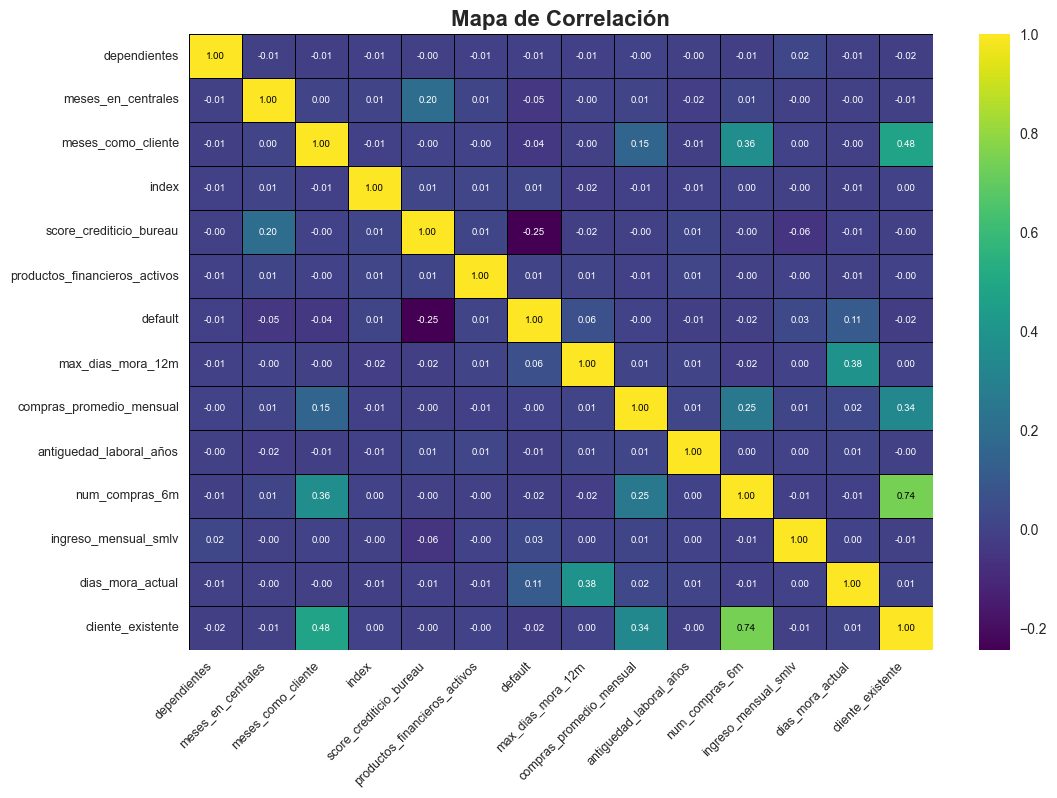

In [70]:
# Filtrar solo columnas numéricas y calcular la matriz de correlación
numeric_columns = df_model_3.select_dtypes(include=['number'])
corr_matrix = numeric_columns.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Crear el mapa de calor con la paleta 'viridis'
heatmap = sns.heatmap(
    corr_matrix,
    cmap='viridis',  # Paleta vibrante
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    linecolor='black',
    cbar=True,
    annot_kws={"size": 7}  # Ajuste del tamaño del texto
)

# Ajustar el color del texto para mayor legibilidad
for text in heatmap.texts:
    val = float(text.get_text())
    text.set_color('white' if val < 0.5 else 'black')  # Texto blanco para valores bajos y negro para altos

# Añadir título y ajustes de ejes
plt.title('Mapa de Correlación', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

# Mostrar el gráfico
plt.show()


## Importancia de variables

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
# Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])]
    return(vif)
 
dataset2 = df_model_3[numeric_columns].drop(['index','default'],axis=1)
calc_vif(dataset2).sort_values(by=['VIF'], ascending=False)

variables      VIF
3         score_crediticio_bureau 11.69371
11              cliente_existente  8.54461
8                  num_compras_6m  5.01512
9            ingreso_mensual_smlv  4.31277
4   productos_financieros_activos  3.42748
7         antiguedad_laboral_años  2.60068
0                    dependientes  2.17752
1              meses_en_centrales  2.07505
2              meses_como_cliente  1.97609
6        compras_promedio_mensual  1.41961
5               max_dias_mora_12m  1.41048
10               dias_mora_actual  1.25567

In [ ]:
# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.max_columns = 120

In [71]:
types = pd.DataFrame(df_model_3.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int64      12
float64     2
object      8
dtype: int64


In [72]:
categoricas = types.index[types[0] == 'O'].values
categoricas

array(['rango_edad', 'genero', 'estado_civil', 'nivel_educativo',
       'tipo_empleo', 'tipo_vivienda', 'categoria_principal',
       'canal_aplicacion'], dtype=object)

In [73]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(df_model_3[line].unique()))+" distinct values")

La variable rango_edad contiene: 5 distinct values
La variable genero contiene: 3 distinct values
La variable estado_civil contiene: 4 distinct values
La variable nivel_educativo contiene: 5 distinct values
La variable tipo_empleo contiene: 3 distinct values
La variable tipo_vivienda contiene: 3 distinct values
La variable categoria_principal contiene: 5 distinct values
La variable canal_aplicacion contiene: 4 distinct values


### Transformacipón onehotencoding

In [74]:
def crea_OneHotEncoding(df, columna):
  le = LabelEncoder()
  le_ajustado=le.fit_transform(df[columna]).reshape(-1,1)
  encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)#sparse=False
  column = [columna+ "_"+ str(i) for i in le.classes_]
  data = encoder.fit_transform(le_ajustado)
  return(pd.DataFrame(data,columns =column))

In [76]:
df_model_3.dtypes

rango_edad                        object
genero                            object
estado_civil                      object
nivel_educativo                   object
tipo_empleo                       object
tipo_vivienda                     object
categoria_principal               object
canal_aplicacion                  object
dependientes                       int64
meses_en_centrales                 int64
meses_como_cliente                 int64
index                              int64
score_crediticio_bureau            int64
productos_financieros_activos      int64
default                            int64
max_dias_mora_12m                  int64
compras_promedio_mensual           int64
antiguedad_laboral_años          float64
num_compras_6m                     int64
ingreso_mensual_smlv             float64
dias_mora_actual                   int64
cliente_existente                  int64
dtype: object

In [77]:
numeric_columns = list(set(types.index[types[0] !="O"].values)-set(['default']))
variables_consolidadas = df_model_3[numeric_columns]
objetivo = df_model_3['default']

categoricas = types.index[types[0] == 'O'].values
for column in categoricas:
  df = crea_OneHotEncoding(df_model_3,column)
  variables_consolidadas = pd.concat([variables_consolidadas,df],axis=1)#,axis=1
  print("Columna ",column, " transformada!")

print("Tamaño final del dataset transformado:",variables_consolidadas.shape)

Columna  rango_edad  transformada!
Columna  genero  transformada!
Columna  estado_civil  transformada!
Columna  nivel_educativo  transformada!
Columna  tipo_empleo  transformada!
Columna  tipo_vivienda  transformada!
Columna  categoria_principal  transformada!
Columna  canal_aplicacion  transformada!
Tamaño final del dataset transformado: (10000, 45)


In [78]:
variables_consolidadas.head()

dependientes  meses_en_centrales  meses_como_cliente  index  \
0             1                   0                   4      0   
1             1                 146                   0      1   
2             0                   9                  95      2   
3             1                  19                  17      3   
4             1                  35                   0      4   

   score_crediticio_bureau  productos_financieros_activos  max_dias_mora_12m  \
0                      677                              3                  0   
1                      683                              4                  1   
2                      533                              0                  0   
3                      750                              0                  0   
4                      666                              3                  0   

   compras_promedio_mensual  antiguedad_laboral_años  num_compras_6m  ...  \
0                    343847                 20.50000               5  ...   
1                         0                 13.40000               0  ...   
2                     29590                 18.20000               2  ...   
3                     21608                 34.40000               4  ...   
4                         0                 10.90000               0  ...   

   tipo_vivienda_Propia  categoria_principal_Deportes  \
0               0.00000                       0.00000   
1               0.00000                       1.00000   
2               1.00000                       0.00000   
3               0.00000                       0.00000   
4               0.00000                       1.00000   

   categoria_principal_Electrodomésticos  categoria_principal_Hogar  \
0                                0.00000                    0.00000   
1                                0.00000                    0.00000   
2                                0.00000                    0.00000   
3                                0.00000                    1.00000   
4                                0.00000                    0.00000   

   categoria_principal_Ropa  categoria_principal_Tecnología  \
0                   0.00000                         1.00000   
1                   0.00000                         0.00000   
2                   1.00000                         0.00000   
3                   0.00000                         0.00000   
4                   0.00000                         0.00000   

   canal_aplicacion_App_Móvil  canal_aplicacion_Call_Center  \
0                     0.00000                       0.00000   
1                     0.00000                       0.00000   
2                     0.00000                       0.00000   
3                     0.00000                       0.00000   
4                     0.00000                       0.00000   

   canal_aplicacion_Online  canal_aplicacion_Tienda_Física  
0                  0.00000                         1.00000  
1                  1.00000                         0.00000  
2                  0.00000                         1.00000  
3                  0.00000                         1.00000  
4                  1.00000                         0.00000  

[5 rows x 45 columns]

In [79]:
variables_consolidadas=variables_consolidadas.drop(['index'], axis=1)
variables_consolidadas.shape

(10000, 44)

In [80]:
variables_consolidadas.columns

Index(['dependientes', 'meses_en_centrales', 'meses_como_cliente',
       'score_crediticio_bureau', 'productos_financieros_activos',
       'max_dias_mora_12m', 'compras_promedio_mensual',
       'antiguedad_laboral_años', 'num_compras_6m', 'ingreso_mensual_smlv',
       'dias_mora_actual', 'cliente_existente', 'rango_edad_Baby Boomer (>55)',
       'rango_edad_Centenials (18-23)', 'rango_edad_Generación X (40-54)',
       'rango_edad_Menores de edad', 'rango_edad_Millennials (24-39)',
       'genero_F', 'genero_M', 'genero_O', 'estado_civil_Casado',
       'estado_civil_Divorciado', 'estado_civil_Soltero', 'estado_civil_Viudo',
       'nivel_educativo_Posgrado', 'nivel_educativo_Primaria',
       'nivel_educativo_Secundaria', 'nivel_educativo_Técnico',
       'nivel_educativo_Universitario', 'tipo_empleo_Empleado',
       'tipo_empleo_Independiente', 'tipo_empleo_Pensionado',
       'tipo_vivienda_Arriendo', 'tipo_vivienda_Familiar',
       'tipo_vivienda_Propia', 'categoria_principa

In [81]:
print("Distribución default: \n",objetivo.value_counts())
print()
print("Distribución default: \n", 100*objetivo.value_counts()/objetivo.shape[0])

Distribución default: 
 default
0    8450
1    1550
Name: count, dtype: int64

Distribución default: 
 default
0   84.50000
1   15.50000
Name: count, dtype: float64


Definicion de modelos

In [82]:
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.20, random_state = 42,stratify=objetivo)
print("Number transactions X_train dataset: ", x_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", x_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (8000, 44)
Number transactions y_train dataset:  (8000,)
Number transactions X_test dataset:  (2000, 44)
Number transactions y_test dataset:  (2000,)


In [83]:
sc_X = StandardScaler()
x_train2 = pd.DataFrame(sc_X.fit_transform(x_train))
x_train2.columns = x_train.columns.values
x_train2.index = x_train.index.values
x_train = x_train2
x_test2 = pd.DataFrame(sc_X.transform(x_test))
x_test2.columns = x_test.columns.values
x_test2.index = x_test.index.values
x_test = x_test2

In [84]:
#### Nivelacion de data train
print(y_train.value_counts())
print()
print(100*y_train.value_counts()/y_train.shape[0])

default
0    6760
1    1240
Name: count, dtype: int64

default
0   84.50000
1   15.50000
Name: count, dtype: float64


In [85]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN
print('Original partición dataset %s' % Counter(y_train))

Original partición dataset Counter({0: 6760, 1: 1240})


In [86]:
%%time
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

print('Original dataset shape %s' % Counter(y_train))

# smoteenn = SMOTEENN(random_state=42)

# X_res, y_res = smoteenn.fit_resample(x_train, y_train)
over = RandomOverSampler(sampling_strategy='auto',random_state=42)
X_res, y_res = over.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 6760, 1: 1240})
Resampled dataset shape Counter({0: 6760, 1: 6760})
CPU times: total: 31.2 ms
Wall time: 28.5 ms


Modelo1 XGBoost

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score

In [88]:
xgboost = XGBClassifier(max_depth=5,learning_rate=0.001, n_estimators=100, gamma=0.5,colsample_bytree=0.5,subsample=0.6)
model1=xgboost.fit(X_res, y_res)
pred_M1 = model1.predict(x_test)

In [89]:
#Evaluate results
acc = accuracy_score(y_test, pred_M1 )
print("XGBoost accuracy es: %3.2f" % (acc)) ##
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_M1))

XGBoost accuracy es: 0.69
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1690
           1       0.28      0.67      0.40       310

    accuracy                           0.69      2000
   macro avg       0.60      0.68      0.59      2000
weighted avg       0.82      0.69      0.73      2000



In [90]:
#Evaluate results
acc = accuracy_score(y_test, pred_M1 )
prec = precision_score(y_test, pred_M1 )
rec = recall_score(y_test, pred_M1 )
f1 = f1_score(y_test, pred_M1 )
f2 = fbeta_score(y_test, pred_M1, beta=2.0)
results = pd.DataFrame([['xgboost', 
acc, prec, rec, f1, f2]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall', 'F1 Score', 
'F2 Score'])
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

     Model  Accuracy  Precision  Recall  F1 Score  F2 Score
0  xgboost   0.68500    0.28320 0.67419   0.39885   0.52831


[[1161  529]
 [ 101  209]]


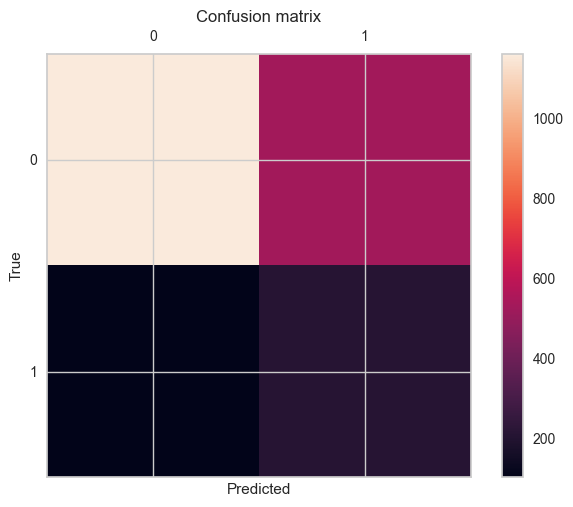

In [91]:
#### Matix de confusion 
cm = confusion_matrix(y_test, pred_M1)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC: 73.2464% 


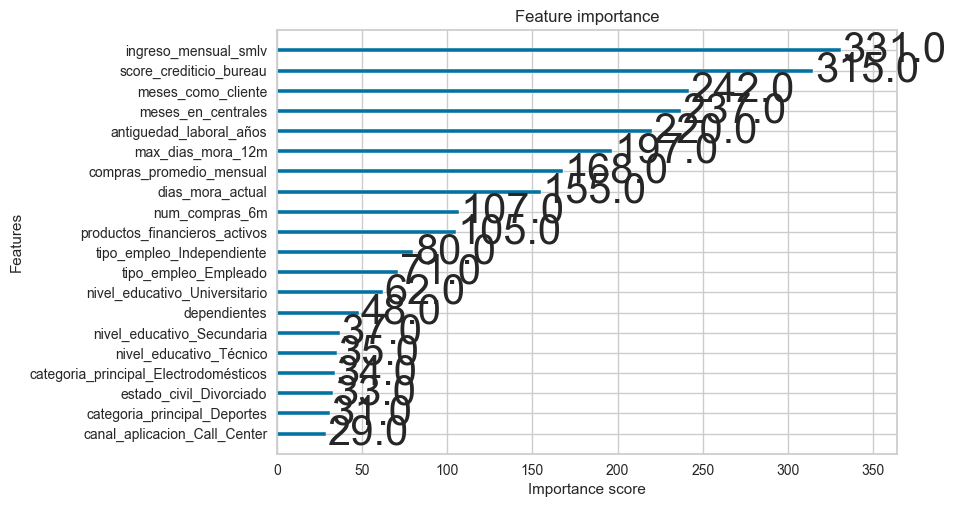

In [92]:
from xgboost import plot_importance
plot_importance(model1, max_num_features=20)

predictions = model1.predict_proba(x_test)[:,1]
roc = roc_auc_score(y_test, predictions)
print("AUC: %.4f%% " % (roc * 100))  

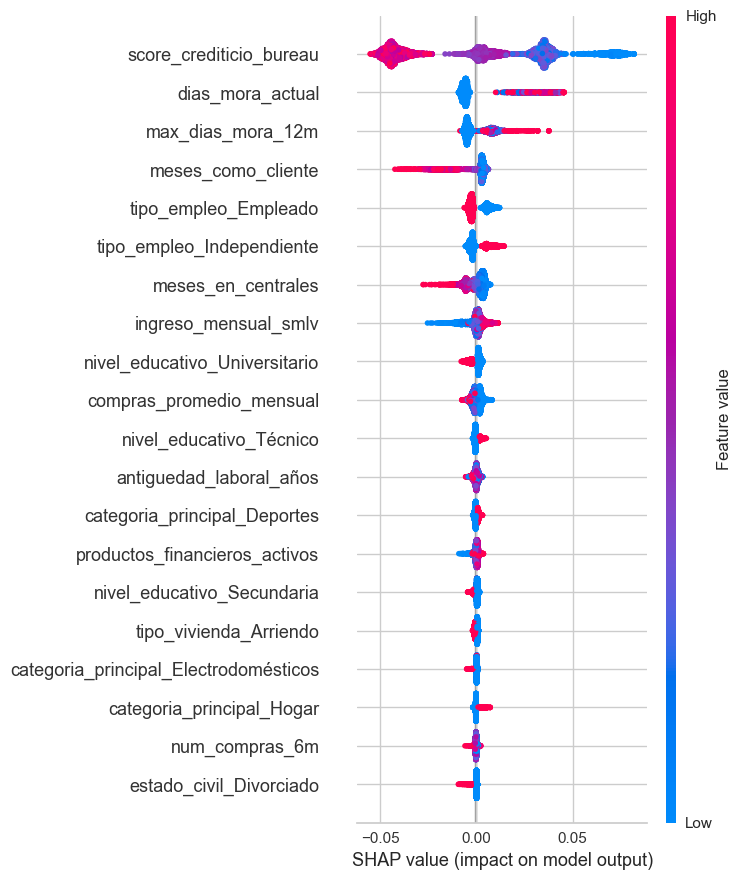

In [93]:
import shap
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_res)
shap.summary_plot(shap_values,X_res)

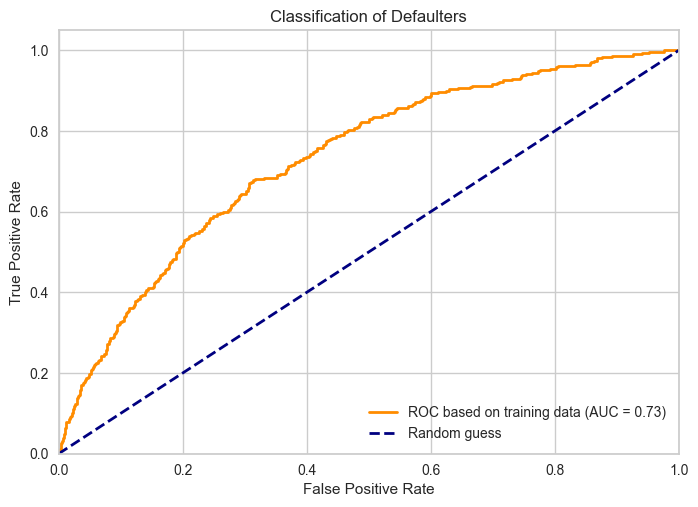

In [94]:
#%matplotlib inline
#Next we plot the ROC curve:
roc_vs = roc_curve(y_test, predictions)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

In [95]:
## Validación overfitting
# print the scores on training and test set

print('Training set score: {:.4f}'.format(model1.score(X_res, y_res)))

print('Test set score: {:.4f}'.format(model1.score(x_test, y_test)))

Training set score: 0.7278
Test set score: 0.6850


In [96]:
#### Guardar 
import pickle
file_name = "./XGB_basic_m1.pkl"
#D:/Proyecto Movil/Modelo 2/

# save
pickle.dump(model1, open(file_name, "wb"))

Modelo 2 random forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

model2_Rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           criterion = 'entropy',
                           random_state = 42)
model2_Rf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [98]:
preds_rf = model2_Rf.predict(x_test)
# accuracy = (preds_rf == y_test).sum().astype(float) / len(preds_rf)*100
#Evaluate results
accuracy = accuracy_score(y_test, preds_rf )
print("Random Forest accuracy es: %3.2f" % (accuracy)) ##
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_rf))

Random Forest accuracy es: 0.84
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1690
           1       0.34      0.05      0.08       310

    accuracy                           0.84      2000
   macro avg       0.60      0.51      0.50      2000
weighted avg       0.77      0.84      0.78      2000



In [99]:
#Evaluate results
acc = accuracy_score(y_test, preds_rf )
prec = precision_score(y_test, preds_rf )
rec = recall_score(y_test, preds_rf)
f1 = f1_score(y_test, preds_rf )
f2 = fbeta_score(y_test, preds_rf, beta=2.0)
model_results = pd.DataFrame(
[['Random Forest basico', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision', 
'Recall', 'F1 Score', 'F2 Score'])
model_results
results = results._append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision  Recall  F1 Score  F2 Score
1  Random Forest basico   0.83850    0.34146 0.04516   0.07977   0.05464
0               xgboost   0.68500    0.28320 0.67419   0.39885   0.52831


In [100]:
print(f"""R^2 Training Score: {model2_Rf.score(X_res, y_res):.2f}
OOB Score: {model2_Rf.oob_score_:.2f}
R^2 Validation Score: {model2_Rf.score(x_test, y_test):.2f}""")

R^2 Training Score: 1.00
OOB Score: 0.99
R^2 Validation Score: 0.84


In [101]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

base_imp = imp_df(X_res.columns, model2_Rf.feature_importances_)
base_imp

feature  feature_importance
0                 score_crediticio_bureau             0.16212
1                    ingreso_mensual_smlv             0.08721
2                      meses_en_centrales             0.08341
3                 antiguedad_laboral_años             0.07906
4                compras_promedio_mensual             0.05760
5                      meses_como_cliente             0.05337
6           productos_financieros_activos             0.04567
7                       max_dias_mora_12m             0.03721
8                            dependientes             0.03579
9                          num_compras_6m             0.03541
10                       dias_mora_actual             0.02780
11         canal_aplicacion_Tienda_Física             0.01383
12                               genero_M             0.01329
13                    estado_civil_Casado             0.01307
14                canal_aplicacion_Online             0.01304
15                   tipo_vivienda_Propia             0.01298
16                               genero_F             0.01250
17         rango_edad_Millennials (24-39)             0.01220
18                 tipo_vivienda_Arriendo             0.01219
19                   estado_civil_Soltero             0.01217
20             nivel_educativo_Secundaria             0.01114
21                nivel_educativo_Técnico             0.01013
22          nivel_educativo_Universitario             0.01007
23        rango_edad_Generación X (40-54)             0.00981
24                 tipo_vivienda_Familiar             0.00961
25           canal_aplicacion_Call_Center             0.00957
26                   tipo_empleo_Empleado             0.00933
27           categoria_principal_Deportes             0.00909
28              tipo_empleo_Independiente             0.00901
29              categoria_principal_Hogar             0.00894
30         categoria_principal_Tecnología             0.00826
31               nivel_educativo_Primaria             0.00777
32             canal_aplicacion_App_Móvil             0.00761
33  categoria_principal_Electrodomésticos             0.00756
34          rango_edad_Centenials (18-23)             0.00753
35               categoria_principal_Ropa             0.00740
36                estado_civil_Divorciado             0.00669
37             rango_edad_Menores de edad             0.00533
38                      cliente_existente             0.00517
39               nivel_educativo_Posgrado             0.00497
40                               genero_O             0.00417
41           rango_edad_Baby Boomer (>55)             0.00411
42                 tipo_empleo_Pensionado             0.00392
43                     estado_civil_Viudo             0.00284

In [102]:
predictions_2 = model2_Rf.predict_proba(x_test)[:,1]
roc = roc_auc_score(y_test, predictions_2)
print("AUC: %.4f%% " % (roc * 100)) 

AUC: 70.5554% 


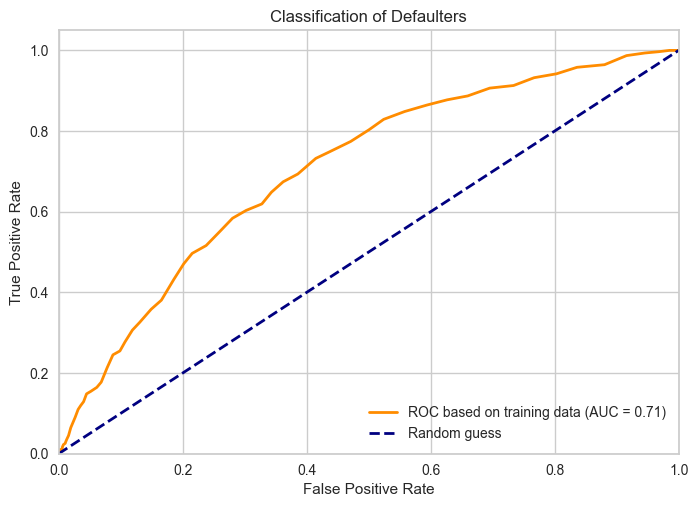

In [103]:
#%matplotlib inline
#Next we plot the ROC curve:
roc_vs = roc_curve(y_test, predictions_2)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

[[1663   27]
 [ 296   14]]


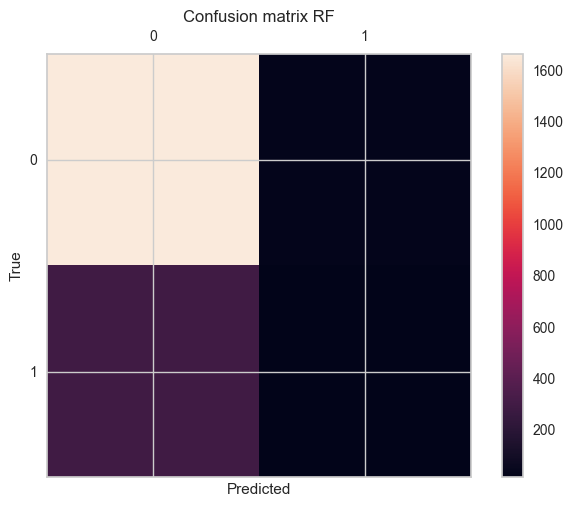

In [104]:
cm = confusion_matrix(y_test, preds_rf)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix RF')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [105]:
## Validación overfitting
# print the scores on training and test set

print('Training set score: {:.4f}'.format(model2_Rf.score(X_res, y_res)))

print('Test set score: {:.4f}'.format(model2_Rf.score(x_test, y_test)))

Training set score: 1.0000
Test set score: 0.8385


In [106]:
import pickle
file_name = "./RF_basic_m2.pkl"
#D:\Proyecto Movil\Modelo 2\

# save
pickle.dump(model2_Rf, open(file_name, "wb"))

Modelo 3 Regresion logistica

In [107]:
from sklearn.linear_model import LogisticRegression

model3_RL = LogisticRegression(penalty='elasticnet',solver='saga',C=0.5,l1_ratio=1)#penalty='none'
model3_RL.fit(X = X_res, y = y_res)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=1, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
preds_RL = model3_RL.predict(x_test)
accuracy = accuracy_score(y_test, preds_RL )
# accuracy = (preds_RL == y_test).sum().astype(float) / len(preds_RL)*100
print("Regresión logistica accuracy es: %3.2f" % (accuracy)) ##
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_RL))

Regresión logistica accuracy es: 0.67
              precision    recall  f1-score   support

           0       0.91      0.67      0.78      1690
           1       0.27      0.65      0.38       310

    accuracy                           0.67      2000
   macro avg       0.59      0.66      0.58      2000
weighted avg       0.81      0.67      0.72      2000



In [109]:
predictions_3 = model3_RL.predict_proba(x_test)[:,1]
roc = roc_auc_score(y_test, predictions_3)
print("AUC: %.4f%% " % (roc * 100))   

AUC: 71.5354% 


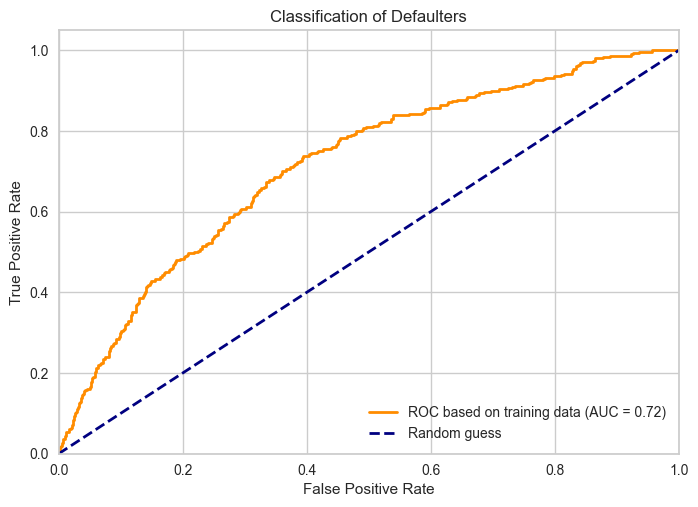

In [110]:
#%matplotlib inline
#Next we plot the ROC curve:
roc_vs = roc_curve(y_test, predictions_3)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

[[1140  550]
 [ 107  203]]


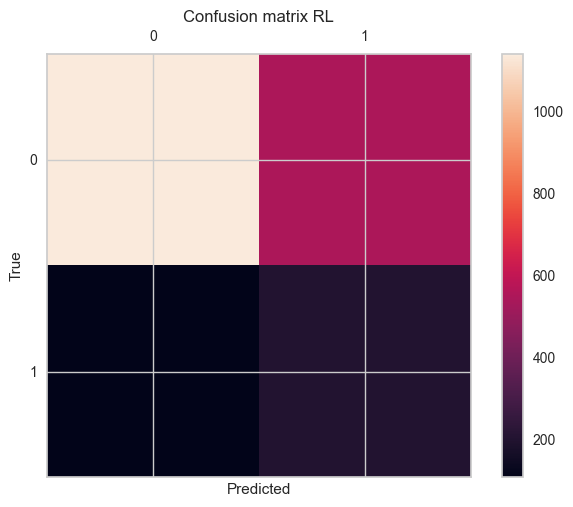

In [111]:
cm = confusion_matrix(y_test, preds_RL)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix RL')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [112]:
#Evaluate results
acc = accuracy_score(y_test, preds_RL )
prec = precision_score(y_test, preds_RL )
rec = recall_score(y_test, preds_RL)
f1 = f1_score(y_test, preds_RL )
f2 = fbeta_score(y_test, preds_RL, beta=2.0)
model_results = pd.DataFrame(
[['Regresión logistica', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision', 
'Recall', 'F1 Score', 'F2 Score'])
results = results._append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision  Recall  F1 Score  F2 Score
0  Random Forest basico   0.83850    0.34146 0.04516   0.07977   0.05464
1               xgboost   0.68500    0.28320 0.67419   0.39885   0.52831
2   Regresión logistica   0.67150    0.26959 0.65484   0.38194   0.50928


In [113]:
### Guardar pesos

import pickle
file_name = "./RL_basic_M3.pkl"
#D:\Proyecto Movil\Modelo 2\

# save
pickle.dump(model3_RL, open(file_name, "wb"))

Modelo 4 LGBoptuna

In [114]:
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, log_loss, classification_report, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, roc_curve
import lightgbm as lgb

#model: LightGBM, XGBoost, LogisticRegression, RandomForest
def Train_Eval_Binary_Model(X_train, X_test, y_train, y_test, model):
    # Modelo de Machine Learning
       
    if model=="LightGBM":
    # Entrenamiento del modelo
        
        # Define la función objetivo para la optimización de Optuna
        def objective(trial):
            params = {
                "objective": "binary",
                "metric": "auc",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "num_leaves": trial.suggest_int("num_leaves", 10, 100),
                "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
                #"feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
                #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
                #"bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
                "random_state": 42
            }

            # Entrena el modelo con los hiperparámetros sugeridos por Optuna
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train)

            # Realiza predicciones en el conjunto de prueba y calcula el AUC-ROC
            y_pred = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred)

            return auc
        
        #Crea un estudio de Optuna y ejecuta la optimizacion de hiperparametros
        study = optuna.create_study(direction="maximize")
        # Setting the logging level WARNING, the INFO logs are suppressed.
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=100)
        
        # Imprime los mejores hiperparámetros encontrados
        best_params = study.best_trial.params
        print("Mejores hiperparámetros encontrados:")
        for param, value in best_params.items():
            print(f"{param}: {value}")

        # Entrena el modelo final con los mejores hiperparámetros
        clf = lgb.LGBMClassifier(**best_params,metric=[ "auc","binary_logloss"])
        
        clf.fit(X_train, y_train,
                eval_set=[(X_train,y_train),(X_test, y_test)])
        

        #grafica funcion de costo durante el entrenamiento
        lgb.plot_metric(clf,metric="binary_logloss", dpi=100,
                        xlabel="Numero de iteraciones",
                        ylabel="Binary log loss",
                        title="Curva de aprendizaje, Evolución Función Costo en cada iteración")

        lgb.plot_metric(clf,metric="auc", dpi=100,
                        xlabel="Numero de iteraciones",
                        ylabel="AUC",
                        title="Curva de aprendizaje, Evolución AUC en cada iteración")
        plt.show()
        
    
    elif model=="XGBoost":
        from xgboost import XGBClassifier
        
        # Define la función objetivo para la optimización de Optuna
        def objective(trial):
            params = {
                "objective": "binary:logistic",
                "eval_metric": "auc",
                "verbosity": 0,
                "booster": "gbtree",
                "n_estimators": trial.suggest_int("n_estimators",50,500),
                "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
                "max_depth": trial.suggest_int("max_depth",3,10),
                "subsample": trial.suggest_float("subsample",0.5,1),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
                "reg_alpha": trial.suggest_float("reg_alpha",0,1),
                "reg_lambda": trial.suggest_float("reg_lambda",0,1),
                "random_state": 42
            }

            # Entrena el modelo con los hiperparámetros sugeridos por Optuna
            model = XGBClassifier(**params)
            model.fit(X_train, y_train)

            # Realiza predicciones en el conjunto de prueba y calcula el AUC-ROC
            y_pred = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred)

            return auc
        
        #Crea un estudio de Optuna y ejecuta la optimizacion de hiperparametros
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100)
        
        # Imprime los mejores hiperparámetros encontrados
        best_params = study.best_trial.params
        print("Mejores hiperparámetros encontrados:")
        for param, value in best_params.items():
            print(f"{param}: {value}")
        
        #modelo
        #eta:learning rate
        #gamma: a mayor gamma mayor regularizacion [0,infinito]
        #max_depth: profundidad maxima del arbol, 0 no hay limite
        #sampling_method: método que se va a usar para muestrear las instancias de entrenamiento
        clf = XGBClassifier(**best_params, eval_metric=["auc","logloss"])

        #entrenamiento del modelo  num_boost_round=100, #numero de iteraciones de refuerzo verbose_eval=10
        clf.fit(X_train,y_train,
                  eval_set=[(X_train,y_train),(X_test, y_test)],verbose=10)
        
        #metricas de train y test es cada epoca de entrenamiento
        results = clf.evals_result()
        epochs = len(results["validation_0"]["auc"])
        x_axis=range(0,epochs)

        fig, ax = plt.subplots(2,1,figsize=(8,10))
        ax[0].plot(x_axis,results["validation_0"]["auc"],label="Train")
        ax[0].plot(x_axis,results["validation_1"]["auc"],label="Test")
        ax[0].set_title("Curva de aprendizaje, Evolución AUC en cada iteración")
        ax[0].set_xlabel("Numero de iteraciones")
        ax[0].set_ylabel("AUC")
        ax[0].legend()
        ax[0].grid()
        ax[1].plot(x_axis,results["validation_0"]["logloss"],label="Train")
        ax[1].plot(x_axis,results["validation_1"]["logloss"],label="Test")
        ax[1].set_title("Curva de aprendizaje, Evolución Función Costo en cada iteración")
        ax[1].set_xlabel("Numero de iteraciones")
        ax[1].set_ylabel("Binary log loss")
        ax[1].legend()
        ax[1].grid()
        plt.show()
        
    elif model=="LogisticRegression":
        from sklearn.linear_model import LogisticRegression

        clf = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000,random_state=0)

        clf.fit(X_train, y_train)
    
    elif model=="RandomForest":
        from sklearn.ensemble import RandomForestClassifier

        clf = RandomForestClassifier(n_estimators=50,  max_depth=10, random_state=0 )

        clf.fit(X_train, y_train)


    # AUC, AR & ROC Curve
    #from sklearn.metrics import roc_auc_score, roc_curve

    y_proba=clf.predict_proba(X_train)[:,1] 
    auc1 = roc_auc_score(y_train.values, y_proba)
    false_positive_rate1, true_positive_rate1, thresolds = roc_curve(y_train.values, y_proba)

    y_proba=clf.predict_proba(X_test)[:,1] 
    auc2 = roc_auc_score(y_test.values, y_proba)
    false_positive_rate2, true_positive_rate2, thresolds = roc_curve(y_test.values, y_proba)

    plt.figure(figsize=(6, 4.5), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC, AR & ROC Curve")
    plt.plot(false_positive_rate1, true_positive_rate1, 'r', label='AUC Train = %0.4f' % auc1)
    plt.plot(false_positive_rate2, true_positive_rate2, 'b', label='AUC Test = %0.4f' % auc2)
    plt.plot([0,1],[0,1],"--",c="red")
    plt.fill_between(false_positive_rate1, true_positive_rate1, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.3, 'AR Train = %0.4f' % (auc1*2-1), ha='right', fontsize=12, weight='bold', color='red')
    plt.text(0.95, 0.2, 'AR Test = %0.4f' % (auc2*2-1), ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    #### Metricas

    # Exactitud
    from sklearn.metrics import accuracy_score

    y_pred=clf.predict(X_train)
    metric=accuracy_score( y_train, y_pred)
    print(f'Base Construccion {model} Exactitud: {metric:0.4f}')

    y_pred=clf.predict(X_test)
    metric=accuracy_score( y_test, y_pred)
    print(f'Base Prueba {model} Exactitud: {metric:0.4f}')

    #y_pred_f=clf.predict(Xf)
    #metric=accuracy_score( yf, y_pred_f)
    #print(f'Base Fuera Muestra {model} Exactitud: {metric:0.4f}')
    print("")

    # Precision
    from sklearn.metrics import precision_score

    y_pred=clf.predict(X_train)
    metric=precision_score( y_train, y_pred)
    print(f'Base Construccion {model} Precision: {metric:0.4f}')

    y_pred=clf.predict(X_test)
    metric=precision_score( y_test, y_pred)
    print(f'Base Prueba {model} Precision: {metric:0.4f}')

    #y_pred_f=clf.predict(Xf)
    #metric=precision_score( yf, y_pred_f)
    #print(f'Base Fuera Muestra {model} Precision: {metric:0.4f}')
    print("")

    # Sensibilidad - Recall
    from sklearn.metrics import recall_score

    y_pred=clf.predict(X_train)
    metric=recall_score( y_train, y_pred)
    print(f'Base Construccion {model} Sensibilidad: {metric:0.4f}')

    y_pred=clf.predict(X_test)
    metric=recall_score( y_test, y_pred)
    print(f'Base Prueba {model} Sensibilidad: {metric:0.4f}')

    #y_pred_f=clf.predict(Xf)
    #metric=recall_score( yf, y_pred_f)
    #print(f'Base Fuera Muestra {model} Sensibilidad: {metric:0.4f}')
    print("")

    # Especificidad
    y_pred=clf.predict(X_train)
    metric=recall_score( y_train, y_pred, pos_label=0)
    print(f'Base Construccion {model} Especificidad: {metric:0.4f}')

    y_pred=clf.predict(X_test)
    metric=recall_score( y_test, y_pred, pos_label=0)
    print(f'Base Prueba {model} Especificidad: {metric:0.4f}')
    print("")
    
    from sklearn.metrics import classification_report
    print(classification_report(y_test.values, clf.predict(X_test)))
    
    #deciles
    def Deciles(y_proba):
        deci="D1,D2,D3,D4,D5,D6,D7,D8,D9,D10".split(",")
        interval_prob = ["[0,15)","[15,25)","[25,35)]","[35,45)","[45,55)","[55,65)","[65,75)","[75,80)","[80,85)","[85,100)"]

        D1 = len(y_proba[y_proba<0.1]) #cantidad de registros con probabilidad menor al 15% de ser 1
        D2 = len(y_proba[np.logical_and( y_proba>=0.1,y_proba<0.2)]) #cantidad registros con probobabilidad entre 15% y 25% de ser 1
        D3 = len(y_proba[np.logical_and( y_proba>=0.2,y_proba<0.3)]) #cantidad registros con probobabilidad entre 25% y 35% de ser 1
        D4 = len(y_proba[np.logical_and( y_proba>=0.3,y_proba<0.4)]) #cantidad registros con probobabilidad entre 35% y 45% de ser 1
        D5 = len(y_proba[np.logical_and( y_proba>=0.4,y_proba<0.5)]) #cantidad registros con probobabilidad entre 45% y 55% de ser 1
        D6 = len(y_proba[np.logical_and( y_proba>=0.5,y_proba<0.6)]) #cantidad registros con probobabilidad entre 55% y 65% de ser 1
        D7 = len(y_proba[np.logical_and( y_proba>=0.6,y_proba<0.7)]) #cantidad registros con probobabilidad entre 65% y 75% de ser 1
        D8 = len(y_proba[np.logical_and( y_proba>=0.7,y_proba<0.8)]) #cantidad registros con probobabilidad entre 75% y 80% de ser 1
        D9 = len(y_proba[np.logical_and( y_proba>=0.8,y_proba<0.9)]) #cantidad registros con probobabilidad entre 80% y 85% de ser 1
        D10 = len(y_proba[y_proba>=0.9]) #cantidad registros con probobabilidad al 85% de ser 1

        deciles=[D1,D2,D3,D4,D5,D6,D7,D8,D9,D10]
        deci="D1,D2,D3,D4,D5,D6,D7,D8,D9,D10".split(",")
        interval_prob = ["[0,10)","[10,20)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100]"]
        bars = ["#"*int(round((i/len(y_proba))*100,0)) for i in deciles]

        return {"Decil":deci, "Intervalo de Probabilidad [%]":interval_prob,"Cantidad de registros":deciles, "Barras":bars}


    from tabulate import tabulate

    print(tabulate( Deciles(clf.predict_proba(X_test)[:,1]),headers="keys", tablefmt="fancy_grid"))
    
    return clf

Mejores hiperparámetros encontrados:
num_leaves: 33
learning_rate: 0.0012426841778027872
min_child_samples: 97
reg_alpha: 0.042837468726985725
reg_lambda: 0.4143864522438115


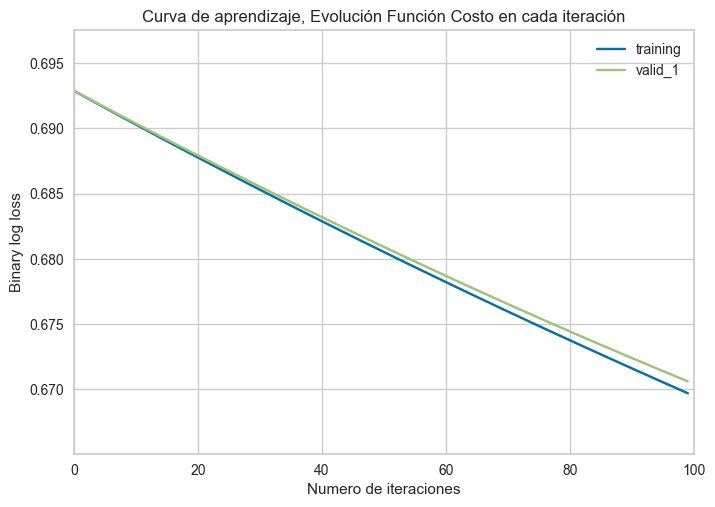

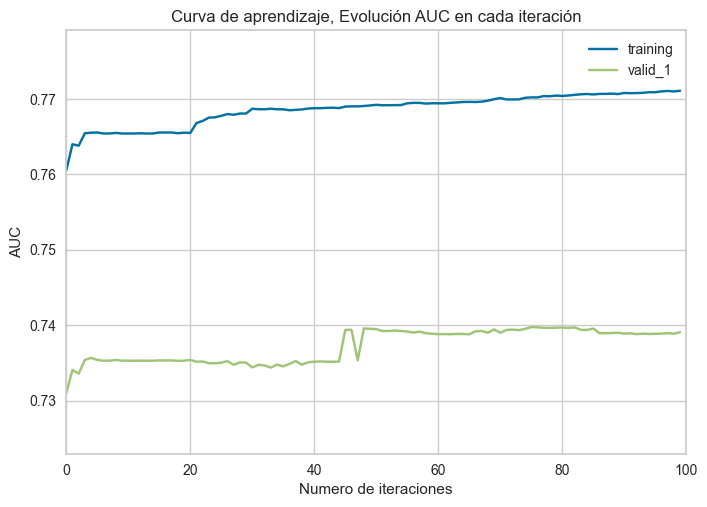

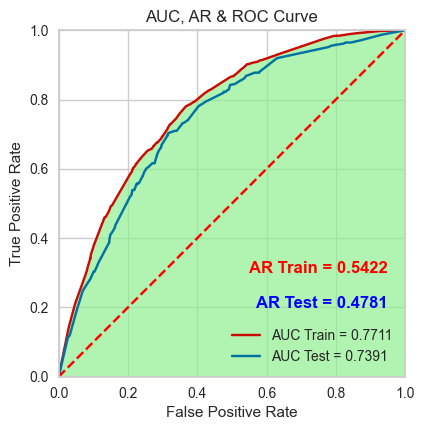

Base Construccion LightGBM Exactitud: 0.7053
Base Prueba LightGBM Exactitud: 0.6670

Base Construccion LightGBM Precision: 0.6852
Base Prueba LightGBM Precision: 0.2764

Base Construccion LightGBM Sensibilidad: 0.7595
Base Prueba LightGBM Sensibilidad: 0.7097

Base Construccion LightGBM Especificidad: 0.6510
Base Prueba LightGBM Especificidad: 0.6592

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1690
           1       0.28      0.71      0.40       310

    accuracy                           0.67      2000
   macro avg       0.60      0.68      0.58      2000
weighted avg       0.82      0.67      0.71      2000

╒═════════╤═════════════════════════════════╤═════════════════════════╤══════════════════════════════════════════════════════════════╕
│ Decil   │ Intervalo de Probabilidad [%]   │   Cantidad de registros │ Barras                                                       │
╞═════════╪═════════════════════════════════╪════

In [115]:
%%time

##Entrenamiento y evaluacion del modelo

model = "LightGBM"
clf1 = Train_Eval_Binary_Model(X_res, x_test,y_res, y_test, model)

Modelo 4 light GBM

In [116]:
preds_LightGBM = clf1.predict(x_test)
accuracy = accuracy_score(y_test, preds_LightGBM )
# accuracy = (preds_RL == y_test).sum().astype(float) / len(preds_RL)*100
print("LightGBM  accuracy es: %3.2f" % (accuracy)) ##
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_LightGBM))

LightGBM  accuracy es: 0.67
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1690
           1       0.28      0.71      0.40       310

    accuracy                           0.67      2000
   macro avg       0.60      0.68      0.58      2000
weighted avg       0.82      0.67      0.71      2000



In [117]:
predictions_4 = clf1.predict_proba(x_test)[:,1]
roc = roc_auc_score(y_test, predictions_4)
print("AUC: %.4f%% " % (roc * 100)) 

AUC: 73.9054% 


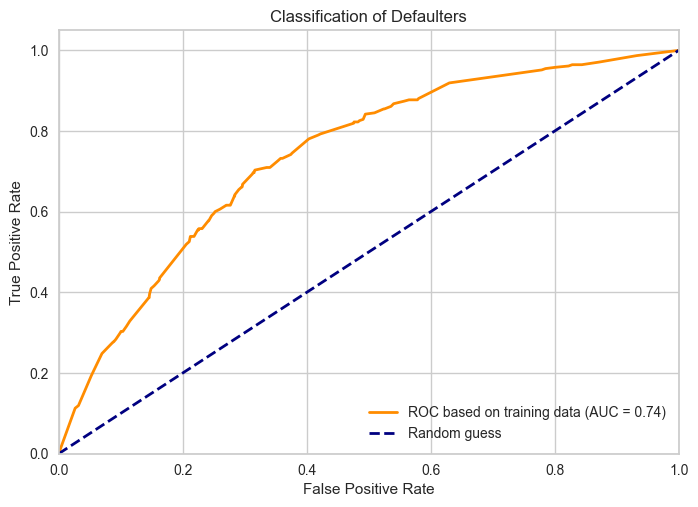

In [118]:
#%matplotlib inline
#Next we plot the ROC curve:
roc_vs = roc_curve(y_test, predictions_4)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

[[1114  576]
 [  90  220]]


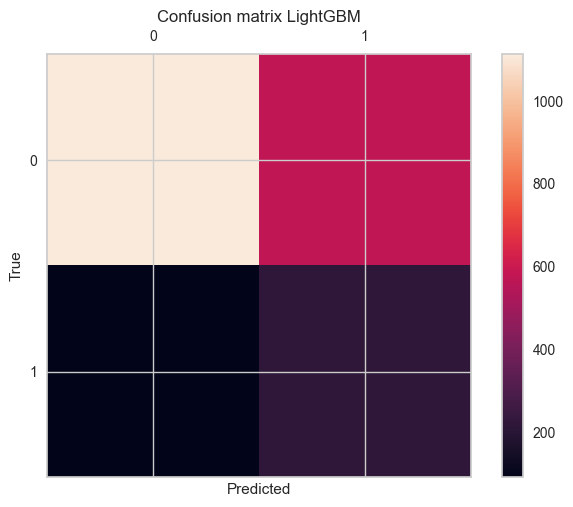

In [119]:
cm = confusion_matrix(y_test, preds_LightGBM)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix LightGBM')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [120]:
## Validación overfitting
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf1.score(X_res, y_res)))

print('Test set score: {:.4f}'.format(clf1.score(x_test, y_test)))

Training set score: 0.7053
Test set score: 0.6670


In [121]:
#Evaluate results
acc = accuracy_score(y_test, preds_LightGBM )
prec = precision_score(y_test, preds_LightGBM )
rec = recall_score(y_test, preds_LightGBM)
f1 = f1_score(y_test, preds_LightGBM )
f2 = fbeta_score(y_test, preds_LightGBM, beta=2.0)
model_results = pd.DataFrame(
[['LightGBM Optuna', acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision', 
'Recall', 'F1 Score', 'F2 Score'])
results = results._append(model_results, ignore_index = True)
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision  Recall  F1 Score  F2 Score
0  Random Forest basico   0.83850    0.34146 0.04516   0.07977   0.05464
1               xgboost   0.68500    0.28320 0.67419   0.39885   0.52831
3       LightGBM Optuna   0.66700    0.27638 0.70968   0.39783   0.54028
2   Regresión logistica   0.67150    0.26959 0.65484   0.38194   0.50928


Conclusiones:

* se elige el modelo LightGBM Optuna por tener un mejor recall y f1 score

In [122]:
import pickle
file_name = "./LightGBM_optuna_M4.pkl"
#D:\Proyecto Movil\Modelo 2\

# save
pickle.dump(clf1, open(file_name, "wb"))

#### comportamiento en deciles

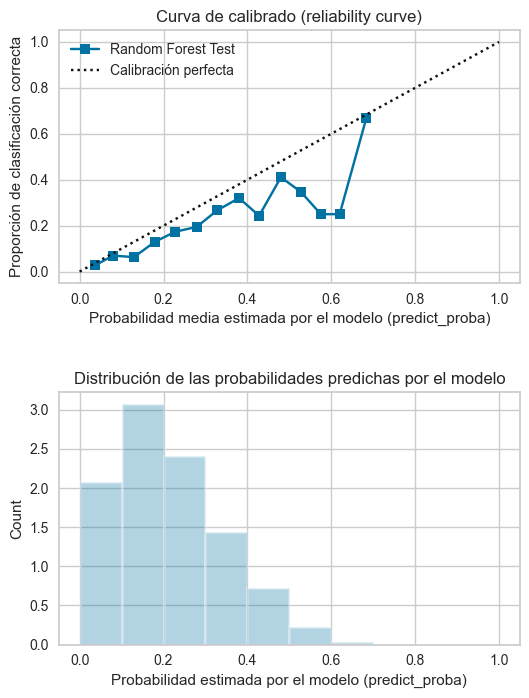

In [124]:
# Predicción con probabilidades
# ==============================================================================
# Se extraen las probabilidades de la clase positiva
prob_positivo = predictions_2
fraccion_positivos, media_prob_predicha = calibration_curve(y_test, prob_positivo, n_bins=20)
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="Random Forest Test")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(prob_positivo, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

LightGBM 

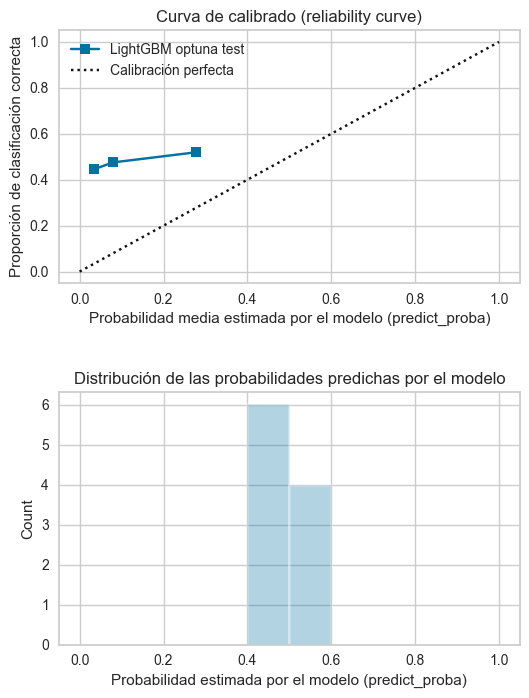

In [123]:
# Predicción con probabilidades
# ==============================================================================
# Se extraen las probabilidades de la clase positiva
prob_positivo_3 = predictions_4
fraccion_positivos_4, media_prob_predicha_4 = calibration_curve(y_test, prob_positivo_3, n_bins=20)


fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(fraccion_positivos_4, media_prob_predicha_4, "s-", label="LightGBM optuna test")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(prob_positivo_3, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

* Mejor comportamiento en deciles y ajuste del modelo es el LightGBM optuna, mejor recall


#### Punto de corte de Cut Off
Encontrar el punto de corte de la probabilidad donde maximicemos especificidad y minimizamos la sensibilidad.

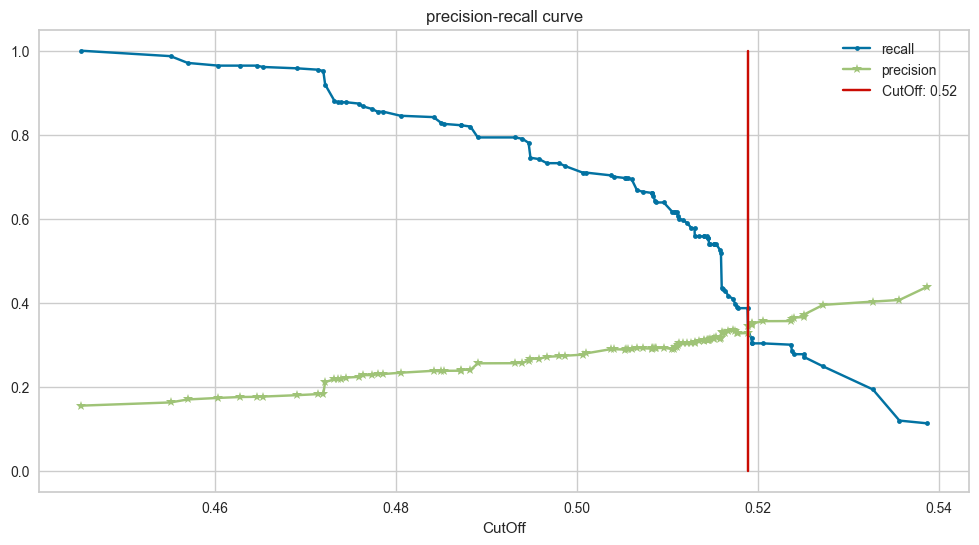

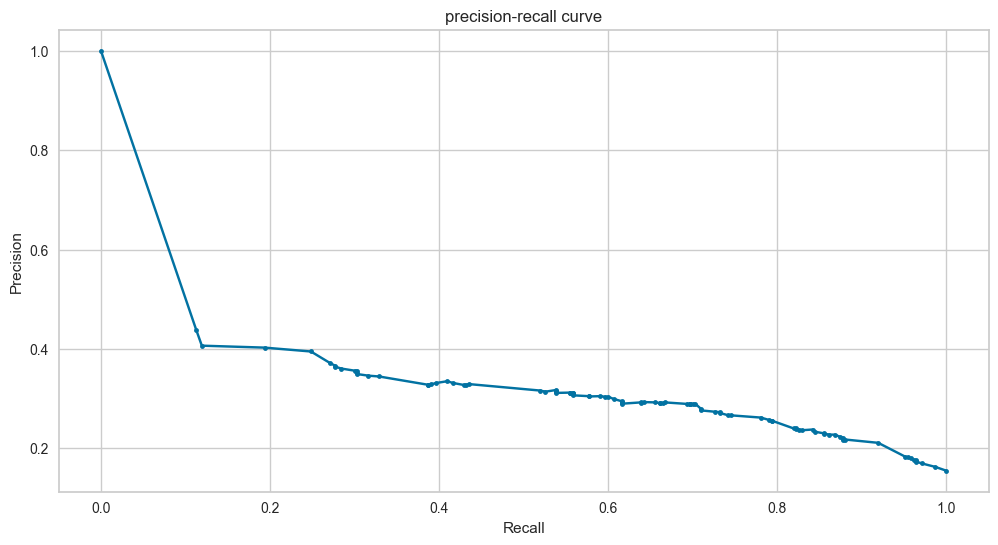

In [126]:
from sklearn.metrics import precision_recall_curve

y_true = y_test
y_pred = preds_LightGBM
y_pred_proba = predictions_4

precision, recall, thresholds_pr = precision_recall_curve(y_true.values,y_pred_proba)

diff = np.abs(recall-precision)

argmin = np.argmin(diff)
# graficar la curva precision-recall

plt.rcParams.update({'font.size':30})

plt.figure(figsize=(12,6),dpi=100)
plt.plot(thresholds_pr,recall[:-1], marker='.',label='recall')
plt.plot(thresholds_pr,precision[:-1], marker='*',label='precision')
plt.plot([thresholds_pr[argmin],thresholds_pr[argmin]], [0,1], 'r', label='CutOff: '+str(round(thresholds_pr[argmin],2)))
plt.xlabel('CutOff')
plt.title('precision-recall curve')
plt.legend()
plt.show()

plt.figure(figsize=(12,6),dpi=100)
plt.plot(recall,precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision-recall curve')
plt.show()


punto de corte ideal probabilistico 0.52

## conclusiones Finales:

#### conclusiones Finales:

* Mejor modelo por precision LightGBM Optuna(optimización de Hiperparametros), el punto de corte ideal de default es de 0.52.





## Fin

-------